# Learning a SDE for the kinetic Ising model

In this tutorial we will impleent a possible way o learn the Itô stochastic equation: 
$$dm_t = \mu_\theta(m_t)dt + \sigma_\theta(m_t)dWt$$
governing the time evolution for the kinetic Ising model, simulated with the Glauber dynamics via Metropolis_hasting samplig.  Here $\mu_\theta$ and $\sigma_\theta$ are intended to be neural networks.
We define the Ising model in terms of classical spins $s_i$ on a 2-dimnesional lattice $\Lambda$,
with a Hmailtonian:
$$
    H(s) = 
    -\frac{1}{2}\sum_
    { \langle  ij\rangle\in \Lambda}s^i s^j.
$$
The transition probabilities are:
$$P(s^i_t \to -s^{i}_t)=
    \begin{cases}
    \exp(- \Delta E/k_{\rm B}T) \quad 
   & \text{if } \Delta E > 0
    \\
    1 &\text{if } \Delta E \leq 0,
    \end{cases}
$$
The method to generate trajectories is in the julia script [generate_data.jl](generate_data.jl)


In [32]:
#generate a data-set of trajectories at a specified temperature

import os
T = 2.269 # Temperature
Size_system = 32
Num_traj = 100
t_max = 10000
dt=0.001 # this is effectively another hyper parameter
#this script generates 100 trajectories for a 64 x 64 lattice up to t=1000
os makedirs("./dataset",exist_of=True)

# To generate the data-set, an installation of julia is needed, hte dataset at T = 2.269 is included

# If you want to generate your own data set, here is the code, on my mac pro from 2015 took 3 min

#os.system("julia generate_data.jl --T %f --Size_system %d --Num_traj %d --t_max %d"%(T,Size_system,Num_traj,t_max)) 


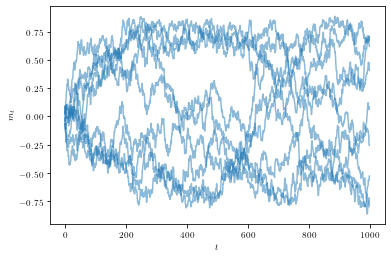

In [122]:
#Let us check the form of the trajectories

import matplotlib.pyplot as plt
import h5py
import numpy as np
# Latex stile ricks and labels
plt.rcParams.update({
                "pgf.texsystem": "pdflatex",
                'font.family': 'serif',
                'text.usetex': True,
                'pgf.rcfonts': False,
                "font.size":9
             })

data_set = "./dataset/N_"+str(Size_system)+"_T_"+str(T)+"_num_traj_"+str(Num_traj)+"t_max_"+str(t_max)+".h5"
f = h5py.File(data_set,"r")
[plt.plot(np.array(f["m1_"+str(n)][:1000]),c="tab:blue",alpha=0.5) for n in range(1,10)]
plt.xlabel(r"$t$")
plt.ylabel(r"$m_t$")
plt.show()

# Learning $\mu_\theta$

To learn the drift $\mu_\theta$ we make use of the infinitesimal generator. For a Stochastic process 
$$
dZ_t = \mu(Z_t)dt + \sigma(Z_t)dW_t, \qquad Z_0=x
$$
The expectation value on the probability distrubution $p^x$ of $Z_t$ is $\mathbb{E}^x[Z_t]$.
The infinitesimal generator is defined as:
$$
\mathcal{W}x
=
\lim_{t\to0^+} \frac{\mathbb{E}^x[m_t]-x}{t}
$$

In [73]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch import optim
# We define the nn representing the mu

class Mu(nn.Module):
    """ 
    This architecture is used to train the 
    drift mu.
    """
    def __init__(self):
        super(Mu, self).__init__()
        self.mu_net =  nn.Sequential(
            nn.Linear(1, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, 1), 
        )   

    def forward(self,v):
           return self.mu_net(v) 
        
class AverageMu(nn.Module):
        """
        Module to compute a weighted average model for the Mu 
        in the hope of better results
        """
        def __init__(self,n_mu=10,weights=torch.ones(10),dt=0.001):
                super(AverageMu, self).__init__()
                if len(weights) != n_mu:
                        raise ValueError("weights must have length n_mu")
                self.funcs = nn.ModuleList([Mu() for _ in range(n_mu)])
                self.weights = weights
                self.dt = dt
        def forward(self,x):
                y = torch.Tensor([0.])
                for w,f in zip(self.weights,self.funcs):
                        y = y + w*f(x)
                return y/self.weights.sum()

        
# the dataset is formed with appoximations to the Wx       

class dataset(Dataset):
    def __init__(self, file_name,thres=0.01,num_trajs=50,t_max = 10000):
        self.ds = h5py.File(file_name,'r')
        self.trajs = np.array([self.ds[key][:t_max] for key in self.ds.keys()])
        self.max = np.max(self.trajs)
        self.min = np.min(self.trajs)
        self.thres = thres
        self.num_trajs = num_trajs
        self.t_max = t_max
    def __getitem__(self,idx):
        x=self.trajs[:self.num_trajs,:self.t_max]

        x0=np.random.rand()*(self.max-self.min) + self.min
        idx = np.argwhere( np.abs(x[:,:-1]-x0)<self.thres  )
        x0s = x[idx[:,0],idx[:,1]]
        x_dt = x[:,1:][idx[:,0],idx[:,1]]
        #                   x                                
        #                 E   (Zt+dt)  - x                   
        #  mu(x) = lim   ------------------- (1)  ------->   E( Zt+1 - Zt) (2) 
        #          dt->0        dt                           
        #
        mu_x = torch.mean( torch.from_numpy(x_dt-x0s))   # (2)
        _x0s_ = torch.from_numpy(x0.reshape(1,))
        return _x0s_.reshape(1,).float(), mu_x.reshape(1,).float()
    def __len__(self):
        return self.trajs.shape[0]



In [74]:
# plot reults to see how training is going
os.makedirs("./images",exist_ok=True)

def plot_results(model,x,y,name = "./images/mu_diff.pdf",dt = dt):
    plt.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
            "font.size":11
         })
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(w=4.7747/1.35, h=2.9841875*0.65)
    fig.tight_layout(pad=1.5)
    with torch.no_grad():

        x, indices = torch.sort(x.flatten())
        y = y.flatten()[indices]
        mu_x_model = model(x.reshape(len(x),1)).detach().numpy().flatten()
        ax.plot(x,y,label = "Data")
        ax.plot(x,mu_x_model*dt,label = "Network")
        ax.set_xlabel(r"$m$")
        ax.set_ylabel(r"$\mu(m)$")
        ax.ticklabel_format(style="sci",scilimits=(0,0))
        ax.legend()
        plt.savefig(name)
        plt.show()
        #plt.close()

In [77]:
#define a training procesure via some loss 

def train_avg_mu(avg_model,
             dataset,
             train_dir,
             batch_size=100,
             input_size=1,
             hidden_size=64,
             output_size=1,
             num_iters=7000,
             stop_every= 100,
             training_diff=False,
             dt=0.001,
             ):  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it) 
    os.makedirs(os.path.dirname(train_dir),exist_ok=True)
    for idx in range(len(avg_model.funcs)):
            model_idx = avg_model.funcs[idx]
            optimizer = optim.RMSprop( model_idx.parameters()  , lr=0.3e-3)
            print("Training for model %d"%idx)
            x0, dx = next(iter(infinite_train_dataloader))
            for global_step in tqdm.tqdm(range(1, num_iters+1)):
                model_idx.zero_grad()
                loss = torch.abs(model_idx(x0)-dx/dt).mean()
                loss.backward()
                optimizer.step()
                if global_step%stop_every==0:
                #    print(loss.item())
                    name = train_dir+"/mu_diff_trai_"+str(idx)+".pdf"
                    plot_results(model_idx,x0,dx,name,dt)
            avg_model.weights[idx] = (((model_idx(x0)*dt-dx)**2).mean()**(-1)).detach()
            avg_model.funcs[idx] = model_idx
    return avg_model


Training for model 0


  1%|▏         | 92/7000 [00:00<00:17, 394.08it/s]

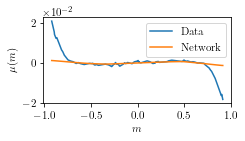

  3%|▎         | 177/7000 [00:00<00:34, 199.82it/s]

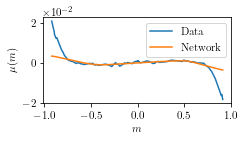

  4%|▎         | 261/7000 [00:01<00:35, 190.16it/s]

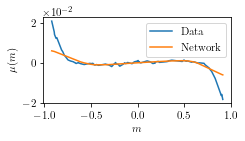

  5%|▌         | 365/7000 [00:01<00:32, 206.31it/s]

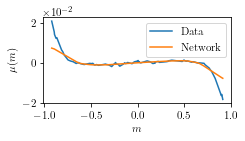

  6%|▋         | 454/7000 [00:02<00:34, 189.32it/s]

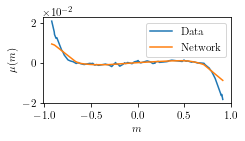

  8%|▊         | 548/7000 [00:02<00:32, 195.99it/s]

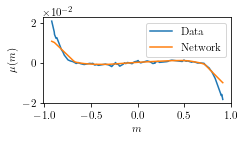

  9%|▉         | 648/7000 [00:03<00:30, 209.80it/s]

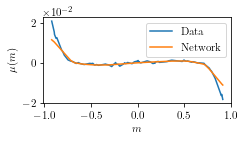

 11%|█         | 763/7000 [00:03<00:32, 192.15it/s]

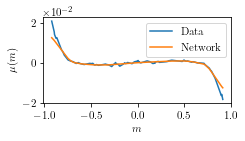

 12%|█▏        | 843/7000 [00:04<00:38, 161.88it/s]

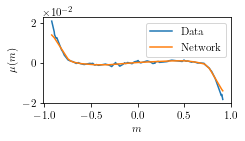

 14%|█▎        | 952/7000 [00:04<00:31, 189.01it/s]

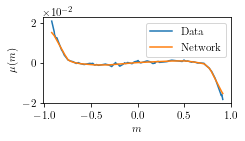

 15%|█▍        | 1049/7000 [00:05<00:30, 193.08it/s]

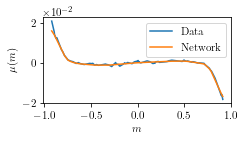

 16%|█▋        | 1155/7000 [00:06<00:29, 200.66it/s]

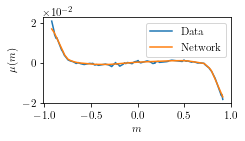

 18%|█▊        | 1294/7000 [00:06<00:22, 253.60it/s]

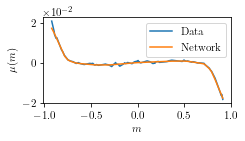

 20%|█▉        | 1385/7000 [00:07<00:26, 213.20it/s]

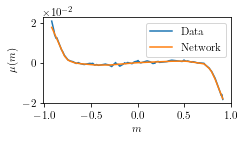

 21%|██        | 1464/7000 [00:07<00:30, 180.86it/s]

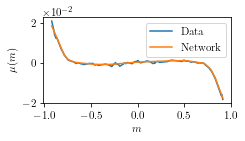

 22%|██▏       | 1554/7000 [00:08<00:33, 164.76it/s]

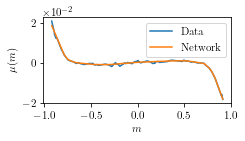

 24%|██▍       | 1672/7000 [00:08<00:31, 167.98it/s]

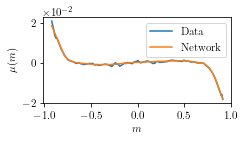

 25%|██▌       | 1764/7000 [00:09<00:32, 159.01it/s]

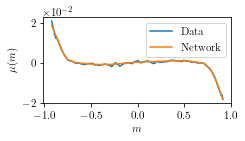

 27%|██▋       | 1857/7000 [00:09<00:28, 178.80it/s]

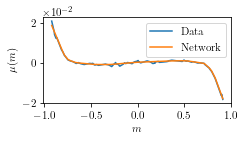

 28%|██▊       | 1957/7000 [00:10<00:26, 189.84it/s]

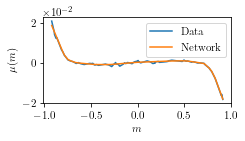

 29%|██▉       | 2063/7000 [00:10<00:25, 190.46it/s]

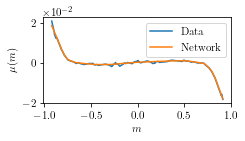

 31%|███       | 2153/7000 [00:11<00:27, 173.80it/s]

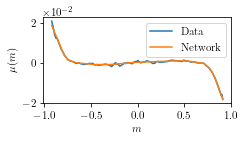

 32%|███▏      | 2258/7000 [00:12<00:24, 196.91it/s]

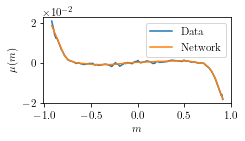

 34%|███▎      | 2358/7000 [00:12<00:23, 201.81it/s]

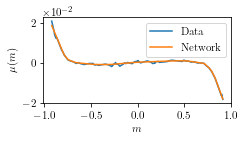

 35%|███▌      | 2457/7000 [00:12<00:21, 210.53it/s]

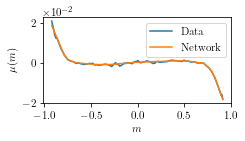

 37%|███▋      | 2557/7000 [00:13<00:21, 208.12it/s]

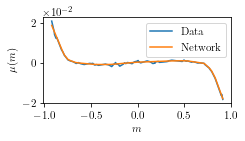

 38%|███▊      | 2656/7000 [00:13<00:20, 215.59it/s]

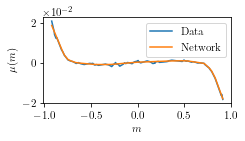

 39%|███▉      | 2756/7000 [00:14<00:20, 211.60it/s]

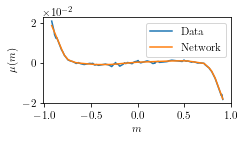

 41%|████      | 2852/7000 [00:14<00:19, 217.10it/s]

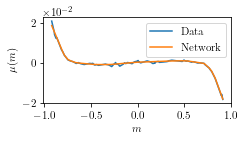

 42%|████▏     | 2955/7000 [00:15<00:19, 212.47it/s]

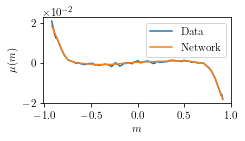

 44%|████▎     | 3055/7000 [00:15<00:17, 221.25it/s]

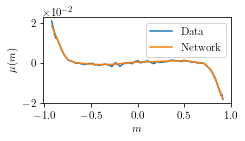

 45%|████▌     | 3153/7000 [00:16<00:18, 208.27it/s]

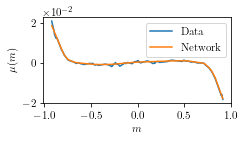

 47%|████▋     | 3256/7000 [00:16<00:16, 223.06it/s]

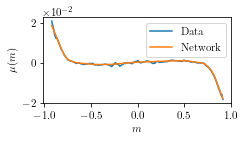

 48%|████▊     | 3391/7000 [00:17<00:15, 234.03it/s]

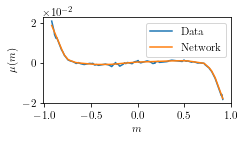

 50%|████▉     | 3474/7000 [00:18<00:18, 189.51it/s]

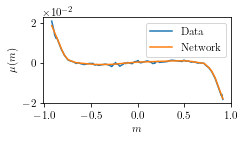

 51%|█████     | 3570/7000 [00:18<00:19, 178.19it/s]

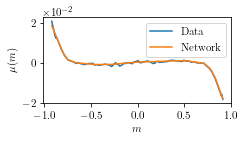

 52%|█████▏    | 3644/7000 [00:19<00:19, 175.06it/s]

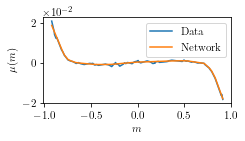

 54%|█████▎    | 3746/7000 [00:19<00:16, 201.34it/s]

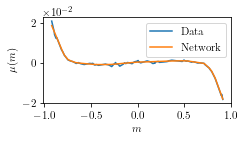

 55%|█████▍    | 3840/7000 [00:20<00:15, 200.08it/s]

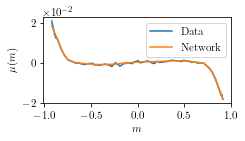

 56%|█████▋    | 3954/7000 [00:20<00:13, 223.53it/s]

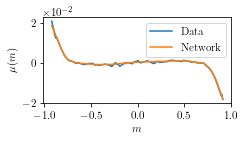

 58%|█████▊    | 4047/7000 [00:21<00:13, 224.17it/s]

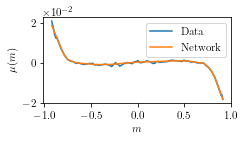

 59%|█████▉    | 4156/7000 [00:21<00:12, 230.08it/s]

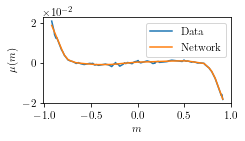

 61%|██████    | 4253/7000 [00:22<00:11, 233.14it/s]

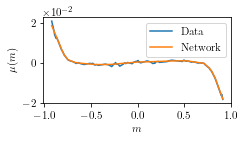

 62%|██████▏   | 4366/7000 [00:22<00:10, 242.83it/s]

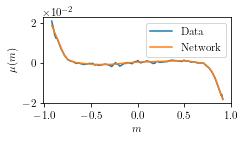

 64%|██████▍   | 4475/7000 [00:22<00:10, 240.82it/s]

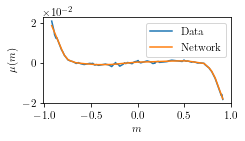

 66%|██████▌   | 4592/7000 [00:23<00:09, 245.76it/s]

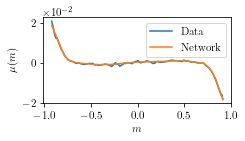

 66%|██████▋   | 4638/7000 [00:23<00:12, 182.12it/s]

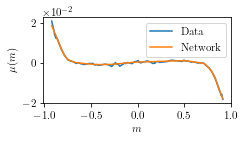

 68%|██████▊   | 4764/7000 [00:24<00:09, 229.69it/s]

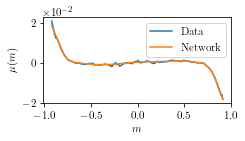

 70%|██████▉   | 4874/7000 [00:24<00:09, 234.47it/s]

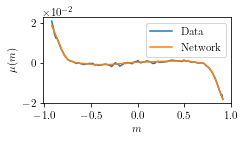

 71%|███████   | 4980/7000 [00:25<00:08, 237.95it/s]

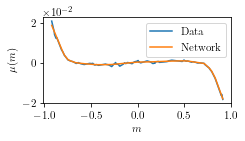

 73%|███████▎  | 5094/7000 [00:25<00:07, 241.85it/s]

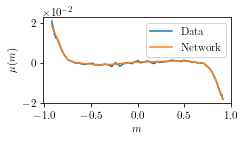

 73%|███████▎  | 5139/7000 [00:25<00:09, 194.19it/s]

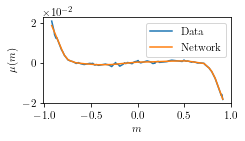

 75%|███████▌  | 5265/7000 [00:26<00:07, 237.54it/s]

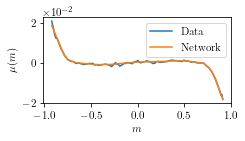

 77%|███████▋  | 5375/7000 [00:26<00:06, 238.59it/s]

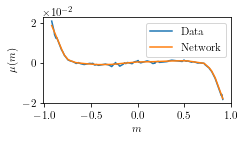

 78%|███████▊  | 5490/7000 [00:27<00:06, 243.18it/s]

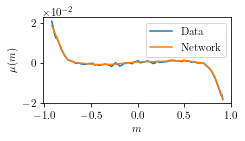

 79%|███████▉  | 5536/7000 [00:27<00:07, 195.46it/s]

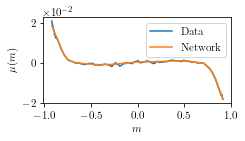

 81%|████████  | 5669/7000 [00:28<00:05, 242.66it/s]

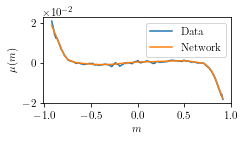

 83%|████████▎ | 5784/7000 [00:28<00:04, 245.11it/s]

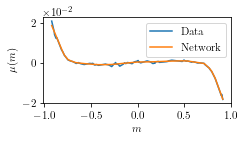

 83%|████████▎ | 5829/7000 [00:28<00:05, 196.41it/s]

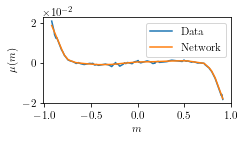

 85%|████████▌ | 5972/7000 [00:29<00:04, 239.22it/s]

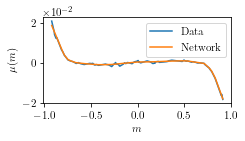

 87%|████████▋ | 6085/7000 [00:29<00:03, 243.08it/s]

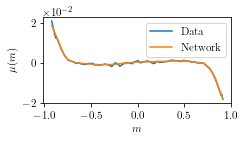

 88%|████████▊ | 6193/7000 [00:30<00:03, 237.81it/s]

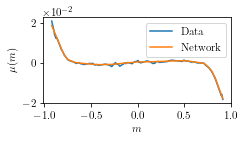

 89%|████████▉ | 6237/7000 [00:30<00:04, 190.68it/s]

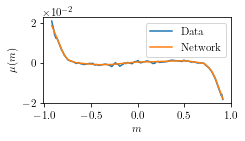

 91%|█████████ | 6365/7000 [00:31<00:02, 235.49it/s]

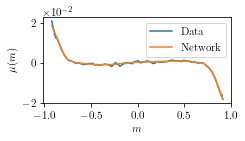

 92%|█████████▏| 6472/7000 [00:31<00:02, 234.21it/s]

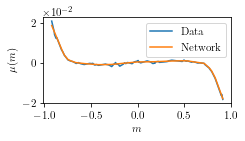

 94%|█████████▍| 6581/7000 [00:31<00:01, 237.76it/s]

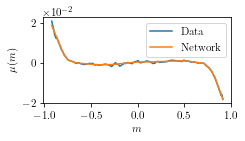

 96%|█████████▌| 6694/7000 [00:32<00:01, 243.90it/s]

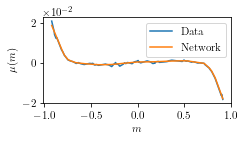

 96%|█████████▋| 6739/7000 [00:32<00:01, 194.26it/s]

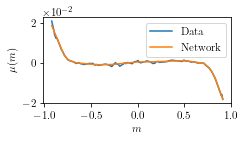

 98%|█████████▊| 6863/7000 [00:33<00:00, 237.11it/s]

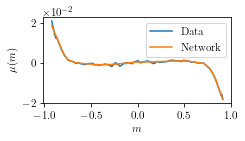

100%|█████████▉| 6967/7000 [00:33<00:00, 234.07it/s]

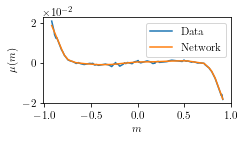

100%|██████████| 7000/7000 [00:33<00:00, 206.61it/s]


Training for model 1


  1%|          | 58/7000 [00:00<00:12, 574.41it/s]

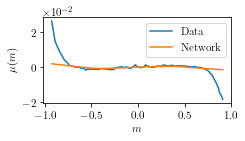

  2%|▏         | 168/7000 [00:00<00:20, 340.55it/s]

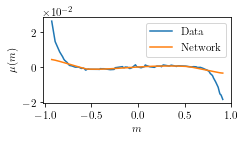

  4%|▍         | 267/7000 [00:01<00:29, 225.00it/s]

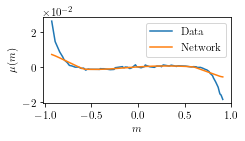

  5%|▌         | 371/7000 [00:01<00:29, 221.43it/s]

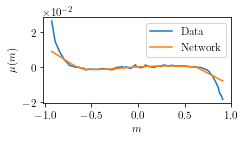

  7%|▋         | 483/7000 [00:01<00:28, 230.34it/s]

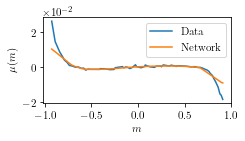

  8%|▊         | 527/7000 [00:02<00:34, 187.81it/s]

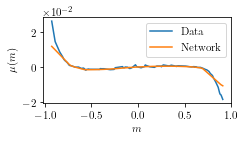

 10%|▉         | 668/7000 [00:02<00:25, 243.77it/s]

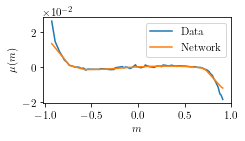

 11%|█         | 774/7000 [00:03<00:25, 242.63it/s]

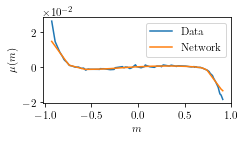

 13%|█▎        | 884/7000 [00:03<00:25, 241.14it/s]

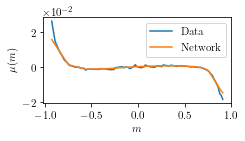

 13%|█▎        | 928/7000 [00:03<00:31, 192.66it/s]

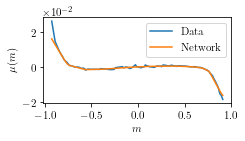

 15%|█▌        | 1067/7000 [00:04<00:24, 246.29it/s]

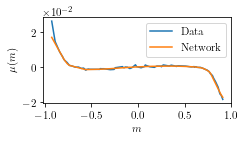

 17%|█▋        | 1174/7000 [00:04<00:24, 241.11it/s]

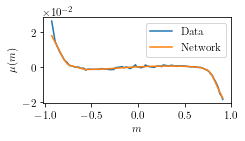

 18%|█▊        | 1288/7000 [00:05<00:23, 244.74it/s]

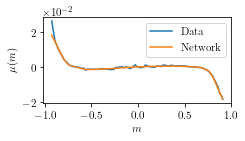

 19%|█▉        | 1333/7000 [00:05<00:29, 195.32it/s]

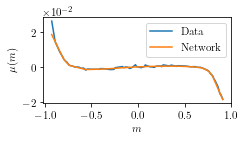

 21%|██        | 1466/7000 [00:06<00:22, 244.73it/s]

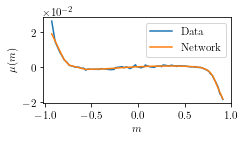

 23%|██▎       | 1578/7000 [00:06<00:24, 224.75it/s]

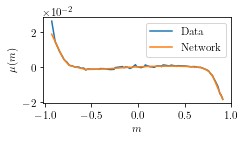

 24%|██▍       | 1693/7000 [00:06<00:22, 234.98it/s]

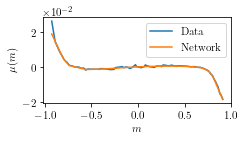

 25%|██▍       | 1739/7000 [00:07<00:27, 193.02it/s]

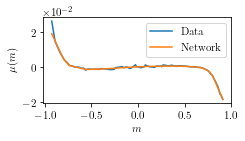

 27%|██▋       | 1869/7000 [00:07<00:21, 239.16it/s]

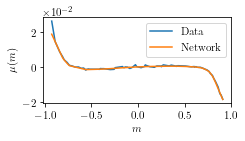

 28%|██▊       | 1981/7000 [00:08<00:20, 240.94it/s]

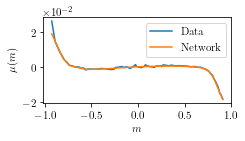

 30%|██▉       | 2096/7000 [00:08<00:20, 239.78it/s]

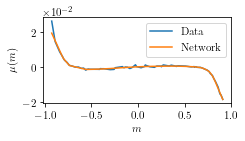

 31%|███       | 2142/7000 [00:08<00:24, 195.35it/s]

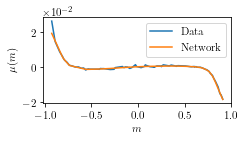

 32%|███▏      | 2268/7000 [00:09<00:19, 237.22it/s]

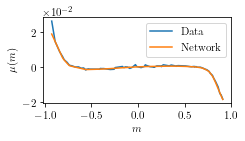

 34%|███▍      | 2380/7000 [00:09<00:19, 239.59it/s]

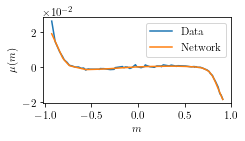

 36%|███▌      | 2494/7000 [00:10<00:18, 245.45it/s]

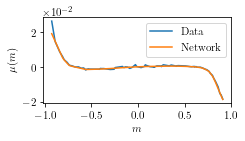

 36%|███▋      | 2540/7000 [00:10<00:22, 197.98it/s]

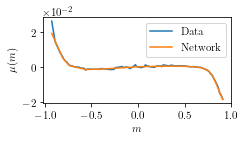

 38%|███▊      | 2668/7000 [00:11<00:17, 241.75it/s]

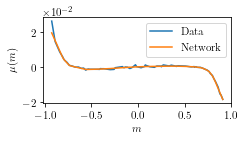

 40%|███▉      | 2781/7000 [00:11<00:17, 244.04it/s]

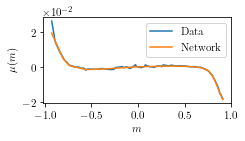

 41%|████▏     | 2899/7000 [00:12<00:17, 232.20it/s]

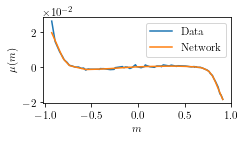

 42%|████▏     | 2945/7000 [00:12<00:21, 191.39it/s]

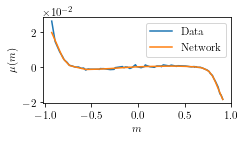

 44%|████▍     | 3069/7000 [00:12<00:16, 232.73it/s]

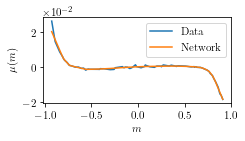

 45%|████▌     | 3182/7000 [00:13<00:16, 238.49it/s]

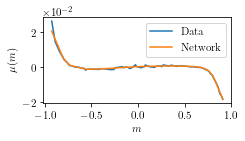

 47%|████▋     | 3299/7000 [00:13<00:15, 245.73it/s]

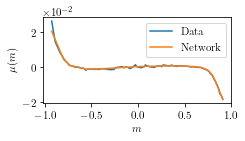

 48%|████▊     | 3345/7000 [00:14<00:18, 198.43it/s]

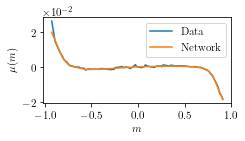

 50%|████▉     | 3465/7000 [00:14<00:15, 235.39it/s]

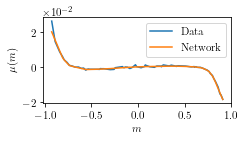

 51%|█████     | 3573/7000 [00:14<00:14, 237.09it/s]

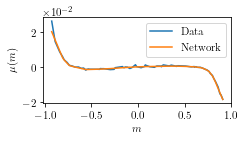

 53%|█████▎    | 3685/7000 [00:15<00:13, 241.50it/s]

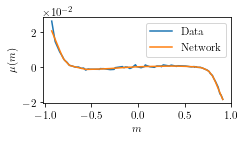

 53%|█████▎    | 3730/7000 [00:15<00:16, 194.22it/s]

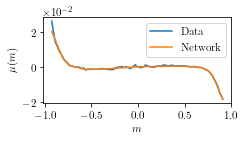

 55%|█████▌    | 3869/7000 [00:16<00:12, 247.25it/s]

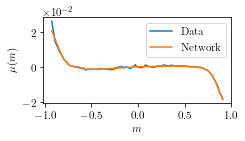

 57%|█████▋    | 3980/7000 [00:16<00:12, 245.67it/s]

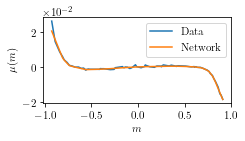

 59%|█████▊    | 4096/7000 [00:17<00:11, 248.43it/s]

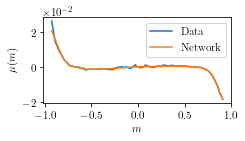

 59%|█████▉    | 4142/7000 [00:17<00:15, 183.52it/s]

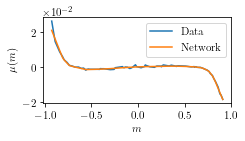

 61%|██████    | 4271/7000 [00:17<00:11, 229.63it/s]

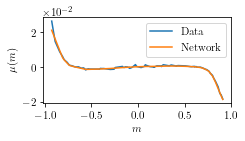

 63%|██████▎   | 4382/7000 [00:18<00:11, 235.50it/s]

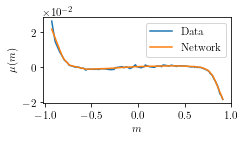

 64%|██████▍   | 4497/7000 [00:18<00:10, 241.78it/s]

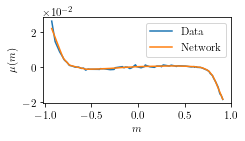

 65%|██████▍   | 4543/7000 [00:19<00:12, 194.35it/s]

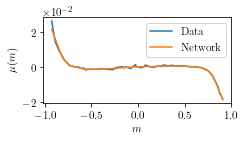

 67%|██████▋   | 4665/7000 [00:19<00:09, 234.36it/s]

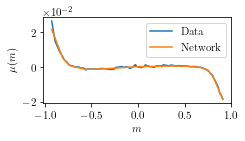

 68%|██████▊   | 4772/7000 [00:19<00:09, 229.54it/s]

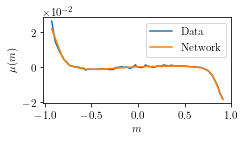

 70%|██████▉   | 4883/7000 [00:20<00:09, 234.57it/s]

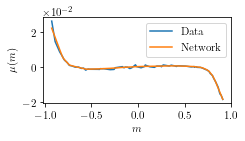

 71%|███████▏  | 4997/7000 [00:20<00:08, 239.48it/s]

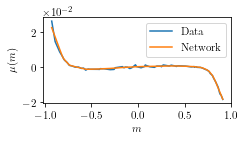

 72%|███████▏  | 5042/7000 [00:21<00:10, 190.68it/s]

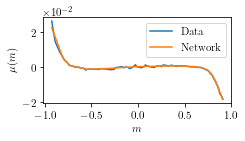

 74%|███████▎  | 5157/7000 [00:21<00:08, 229.44it/s]

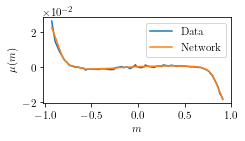

 75%|███████▌  | 5269/7000 [00:22<00:07, 240.06it/s]

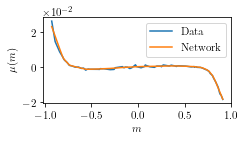

 77%|███████▋  | 5384/7000 [00:22<00:06, 242.62it/s]

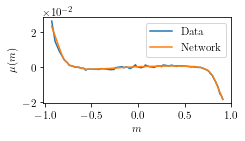

 79%|███████▊  | 5499/7000 [00:23<00:06, 230.48it/s]

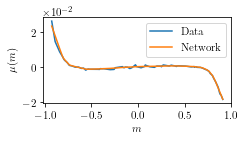

 79%|███████▉  | 5545/7000 [00:23<00:07, 183.45it/s]

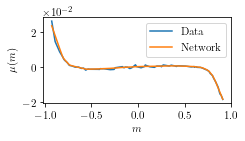

 81%|████████  | 5669/7000 [00:23<00:05, 223.59it/s]

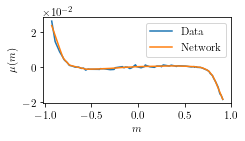

 83%|████████▎ | 5782/7000 [00:24<00:05, 232.91it/s]

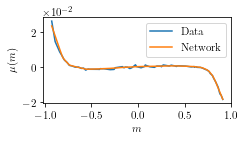

 84%|████████▍ | 5895/7000 [00:24<00:04, 241.25it/s]

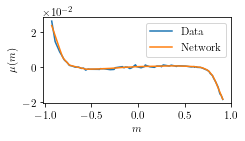

 85%|████████▍ | 5940/7000 [00:25<00:05, 193.66it/s]

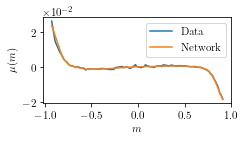

 87%|████████▋ | 6066/7000 [00:25<00:03, 236.35it/s]

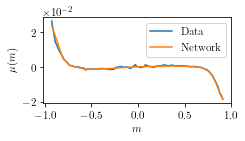

 88%|████████▊ | 6167/7000 [00:25<00:03, 231.10it/s]

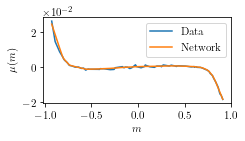

 90%|████████▉ | 6278/7000 [00:26<00:03, 235.09it/s]

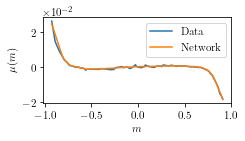

 91%|█████████▏| 6390/7000 [00:26<00:02, 241.15it/s]

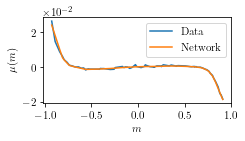

 92%|█████████▏| 6435/7000 [00:27<00:02, 192.92it/s]

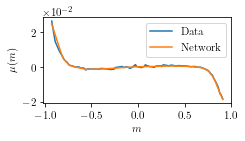

 94%|█████████▎| 6562/7000 [00:27<00:01, 238.81it/s]

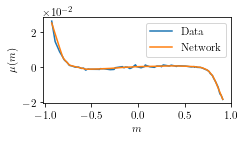

 95%|█████████▌| 6668/7000 [00:28<00:01, 237.86it/s]

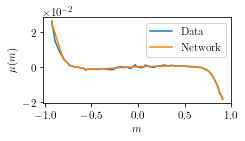

 97%|█████████▋| 6779/7000 [00:28<00:00, 223.27it/s]

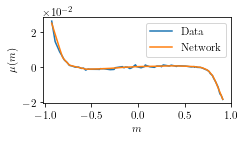

 98%|█████████▊| 6892/7000 [00:29<00:00, 234.25it/s]

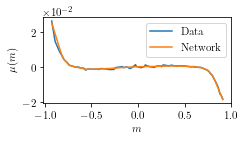

 99%|█████████▉| 6937/7000 [00:29<00:00, 190.06it/s]

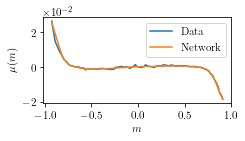

100%|██████████| 7000/7000 [00:29<00:00, 235.63it/s]


Training for model 2


  1%|          | 64/7000 [00:00<00:10, 638.51it/s]

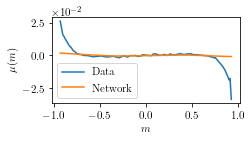

  2%|▏         | 162/7000 [00:00<00:22, 307.39it/s]

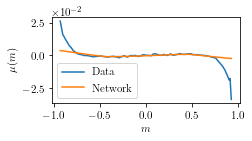

  4%|▍         | 265/7000 [00:00<00:26, 258.40it/s]

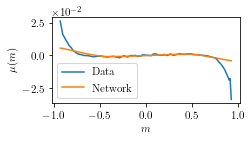

  5%|▌         | 369/7000 [00:01<00:28, 236.23it/s]

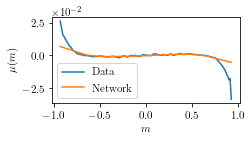

  7%|▋         | 481/7000 [00:01<00:27, 236.50it/s]

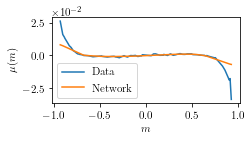

  9%|▊         | 596/7000 [00:02<00:26, 242.95it/s]

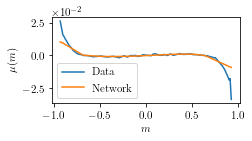

  9%|▉         | 642/7000 [00:02<00:32, 194.88it/s]

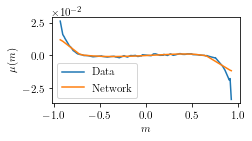

 11%|█         | 770/7000 [00:03<00:26, 237.19it/s]

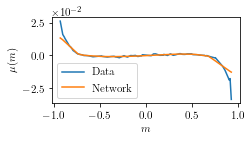

 13%|█▎        | 880/7000 [00:03<00:25, 236.20it/s]

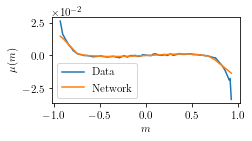

 14%|█▍        | 996/7000 [00:03<00:24, 243.64it/s]

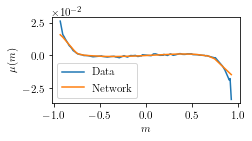

 15%|█▍        | 1042/7000 [00:04<00:32, 181.21it/s]

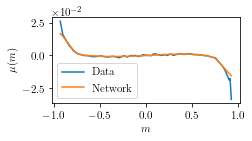

 17%|█▋        | 1172/7000 [00:04<00:25, 225.25it/s]

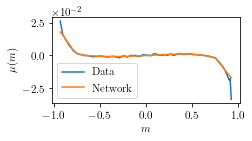

 18%|█▊        | 1285/7000 [00:05<00:24, 233.12it/s]

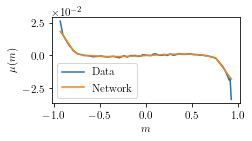

 19%|█▉        | 1330/7000 [00:05<00:29, 189.19it/s]

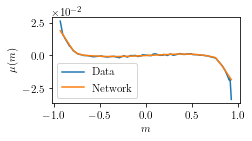

 21%|██        | 1465/7000 [00:06<00:23, 239.98it/s]

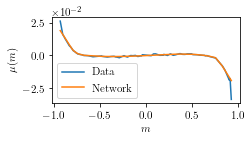

 22%|██▏       | 1573/7000 [00:06<00:22, 239.10it/s]

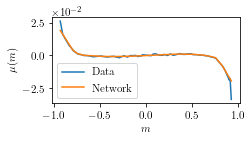

 24%|██▍       | 1686/7000 [00:06<00:21, 241.80it/s]

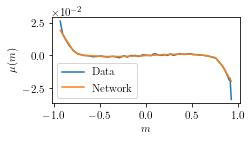

 25%|██▍       | 1731/7000 [00:07<00:27, 192.22it/s]

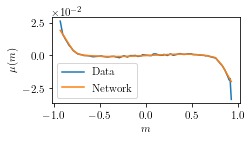

 27%|██▋       | 1871/7000 [00:07<00:20, 244.34it/s]

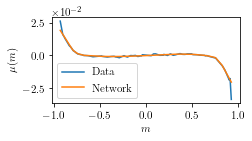

 28%|██▊       | 1986/7000 [00:08<00:20, 244.74it/s]

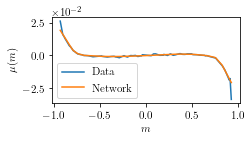

 30%|██▉       | 2096/7000 [00:08<00:19, 245.75it/s]

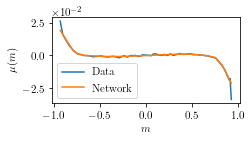

 31%|███       | 2141/7000 [00:09<00:25, 192.32it/s]

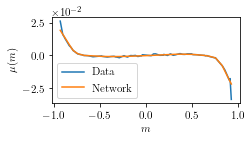

 32%|███▏      | 2267/7000 [00:09<00:20, 234.82it/s]

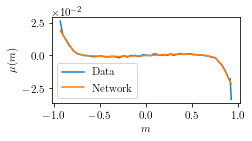

 34%|███▍      | 2376/7000 [00:09<00:21, 217.44it/s]

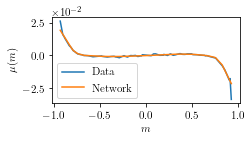

 36%|███▌      | 2491/7000 [00:10<00:19, 231.86it/s]

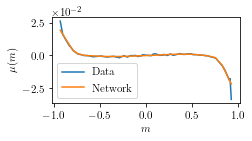

 36%|███▌      | 2536/7000 [00:10<00:23, 188.62it/s]

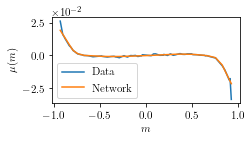

 38%|███▊      | 2662/7000 [00:11<00:18, 234.08it/s]

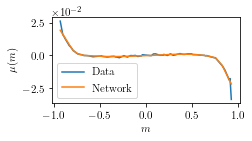

 40%|███▉      | 2769/7000 [00:11<00:18, 233.46it/s]

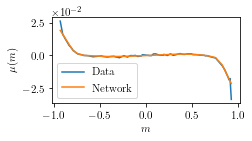

 41%|████      | 2884/7000 [00:12<00:17, 236.91it/s]

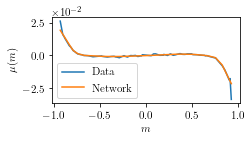

 42%|████▏     | 2929/7000 [00:12<00:21, 191.47it/s]

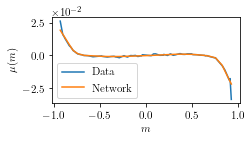

 44%|████▍     | 3072/7000 [00:12<00:15, 246.22it/s]

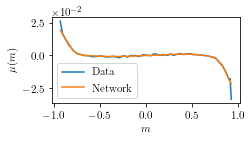

 46%|████▌     | 3188/7000 [00:13<00:15, 246.75it/s]

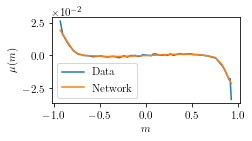

 46%|████▌     | 3234/7000 [00:13<00:19, 197.22it/s]

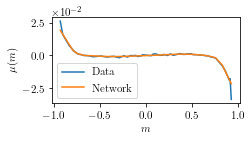

 48%|████▊     | 3371/7000 [00:14<00:14, 246.16it/s]

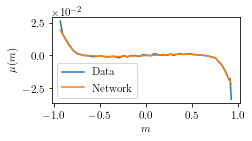

 50%|████▉     | 3480/7000 [00:14<00:14, 243.98it/s]

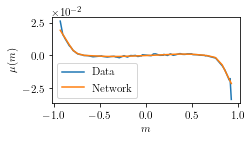

 51%|█████▏    | 3591/7000 [00:15<00:13, 244.98it/s]

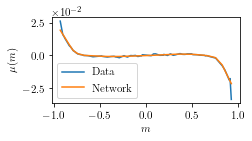

 52%|█████▏    | 3635/7000 [00:15<00:18, 177.95it/s]

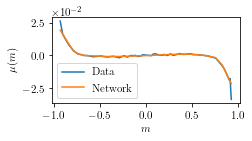

 54%|█████▍    | 3768/7000 [00:15<00:14, 229.06it/s]

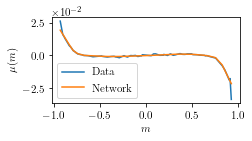

 55%|█████▌    | 3880/7000 [00:16<00:13, 233.27it/s]

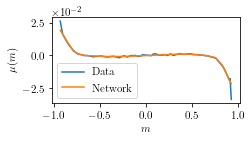

 57%|█████▋    | 3995/7000 [00:16<00:12, 241.36it/s]

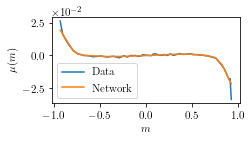

 58%|█████▊    | 4041/7000 [00:17<00:15, 193.76it/s]

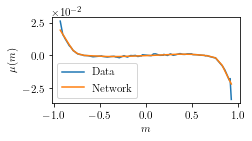

 60%|█████▉    | 4169/7000 [00:17<00:11, 237.29it/s]

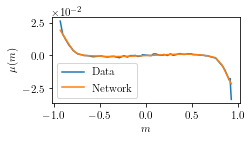

 61%|██████    | 4280/7000 [00:17<00:11, 239.08it/s]

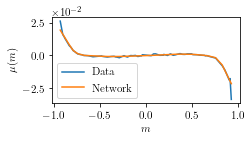

 63%|██████▎   | 4396/7000 [00:18<00:10, 244.27it/s]

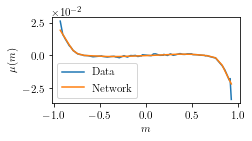

 63%|██████▎   | 4442/7000 [00:18<00:13, 195.96it/s]

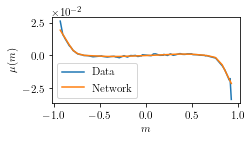

 65%|██████▌   | 4566/7000 [00:19<00:10, 236.46it/s]

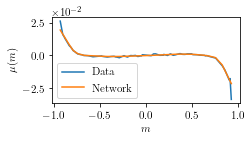

 67%|██████▋   | 4675/7000 [00:19<00:09, 237.24it/s]

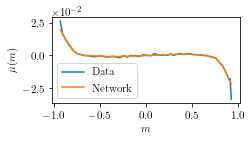

 68%|██████▊   | 4793/7000 [00:20<00:09, 241.19it/s]

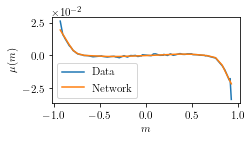

 69%|██████▉   | 4839/7000 [00:20<00:11, 194.89it/s]

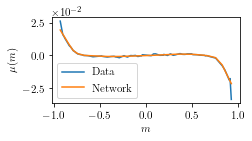

 71%|███████   | 4964/7000 [00:20<00:09, 225.79it/s]

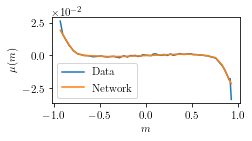

 72%|███████▏  | 5071/7000 [00:21<00:08, 228.01it/s]

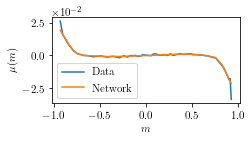

 74%|███████▍  | 5185/7000 [00:21<00:07, 236.42it/s]

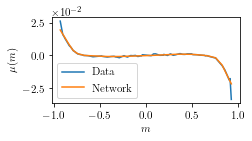

 75%|███████▍  | 5230/7000 [00:22<00:09, 190.05it/s]

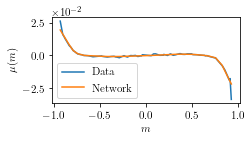

 77%|███████▋  | 5365/7000 [00:22<00:06, 239.81it/s]

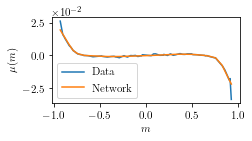

 78%|███████▊  | 5473/7000 [00:23<00:06, 237.11it/s]

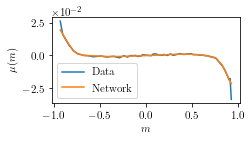

 80%|███████▉  | 5585/7000 [00:23<00:05, 241.11it/s]

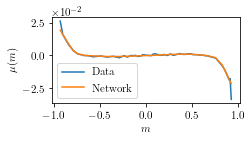

 80%|████████  | 5630/7000 [00:23<00:07, 193.34it/s]

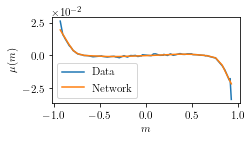

 82%|████████▏ | 5767/7000 [00:24<00:05, 244.45it/s]

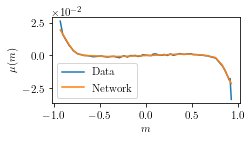

 84%|████████▍ | 5876/7000 [00:24<00:04, 237.98it/s]

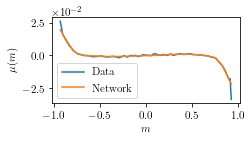

 86%|████████▌ | 5990/7000 [00:25<00:04, 241.70it/s]

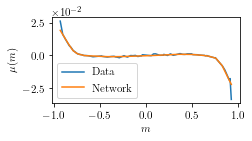

 86%|████████▌ | 6035/7000 [00:25<00:05, 192.79it/s]

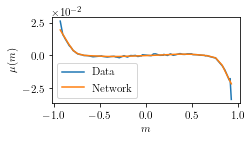

 88%|████████▊ | 6168/7000 [00:26<00:03, 233.97it/s]

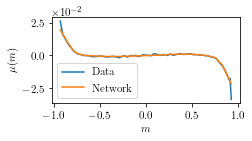

 89%|████████▉ | 6253/7000 [00:26<00:03, 197.21it/s]

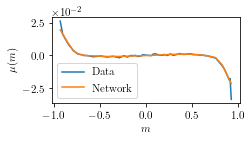

 91%|█████████ | 6368/7000 [00:27<00:02, 224.06it/s]

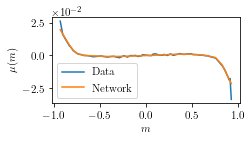

 92%|█████████▎| 6475/7000 [00:27<00:02, 229.46it/s]

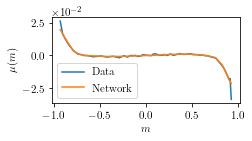

 94%|█████████▍| 6585/7000 [00:27<00:01, 230.42it/s]

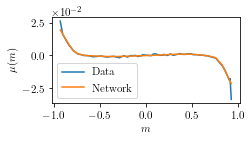

 96%|█████████▌| 6694/7000 [00:28<00:01, 236.70it/s]

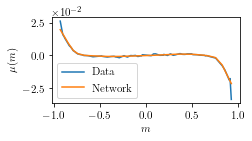

 96%|█████████▋| 6738/7000 [00:28<00:01, 169.34it/s]

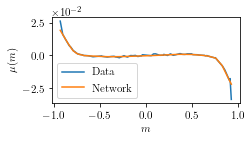

 98%|█████████▊| 6866/7000 [00:29<00:00, 215.97it/s]

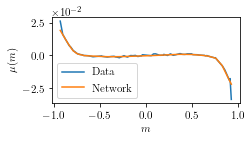

100%|█████████▉| 6970/7000 [00:29<00:00, 220.62it/s]

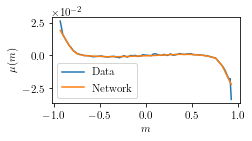

100%|██████████| 7000/7000 [00:30<00:00, 232.84it/s]


Training for model 3


  1%|          | 73/7000 [00:00<00:09, 728.94it/s]

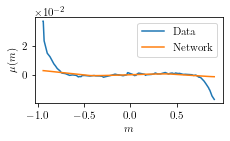

  2%|▏         | 168/7000 [00:00<00:23, 296.05it/s]

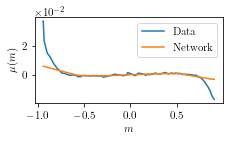

  4%|▍         | 267/7000 [00:00<00:27, 245.81it/s]

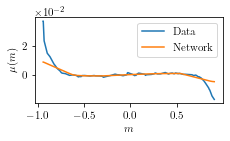

  5%|▌         | 372/7000 [00:01<00:27, 242.37it/s]

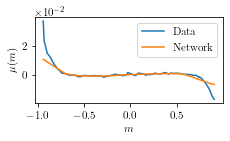

  7%|▋         | 482/7000 [00:01<00:26, 245.57it/s]

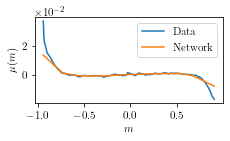

  9%|▊         | 599/7000 [00:02<00:25, 254.01it/s]

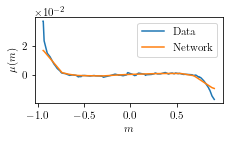

  9%|▉         | 645/7000 [00:02<00:34, 186.25it/s]

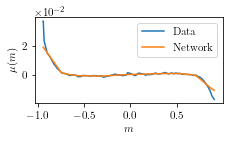

 11%|█         | 764/7000 [00:02<00:27, 226.94it/s]

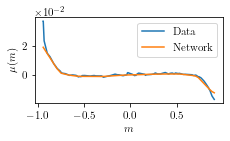

 12%|█▏        | 866/7000 [00:03<00:26, 231.04it/s]

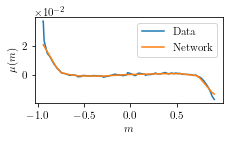

 14%|█▍        | 975/7000 [00:03<00:25, 238.88it/s]

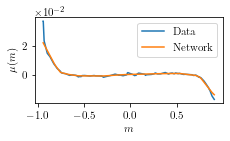

 15%|█▌        | 1084/7000 [00:04<00:24, 245.11it/s]

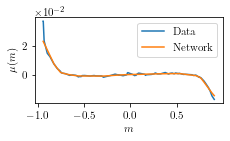

 17%|█▋        | 1198/7000 [00:04<00:22, 252.27it/s]

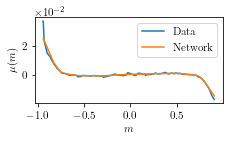

 18%|█▊        | 1244/7000 [00:04<00:28, 204.26it/s]

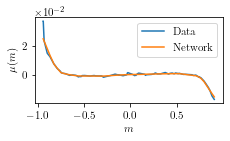

 20%|█▉        | 1369/7000 [00:05<00:22, 246.40it/s]

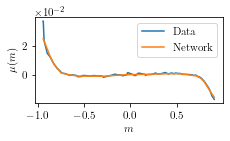

 21%|██        | 1481/7000 [00:05<00:22, 250.02it/s]

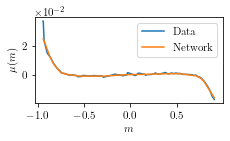

 23%|██▎       | 1597/7000 [00:06<00:20, 257.58it/s]

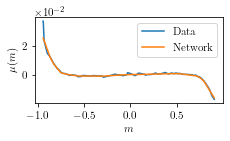

 23%|██▎       | 1643/7000 [00:06<00:25, 206.51it/s]

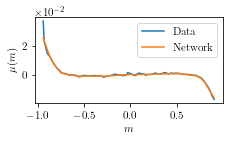

 25%|██▌       | 1767/7000 [00:07<00:21, 247.30it/s]

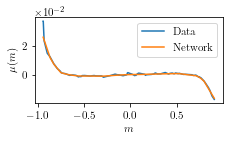

 27%|██▋       | 1877/7000 [00:07<00:20, 250.60it/s]

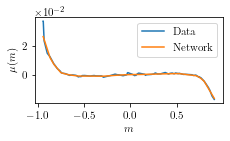

 28%|██▊       | 1993/7000 [00:07<00:19, 256.06it/s]

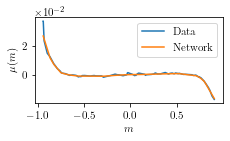

 29%|██▉       | 2039/7000 [00:08<00:26, 185.05it/s]

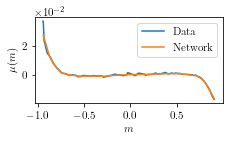

 31%|███       | 2153/7000 [00:08<00:21, 228.40it/s]

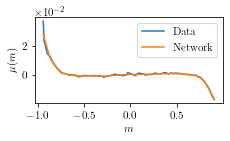

 32%|███▏      | 2255/7000 [00:09<00:20, 235.93it/s]

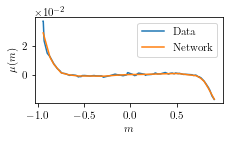

 34%|███▎      | 2361/7000 [00:09<00:19, 241.64it/s]

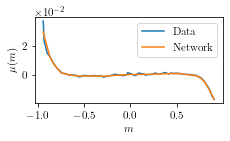

 35%|███▌      | 2475/7000 [00:10<00:20, 225.86it/s]

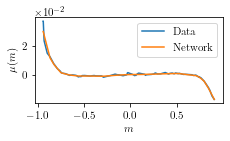

 37%|███▋      | 2567/7000 [00:10<00:23, 192.62it/s]

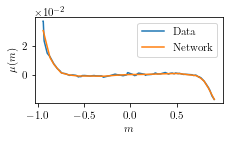

 38%|███▊      | 2657/7000 [00:11<00:22, 194.25it/s]

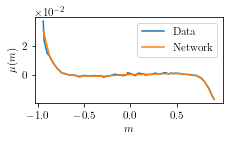

 39%|███▉      | 2758/7000 [00:11<00:20, 208.36it/s]

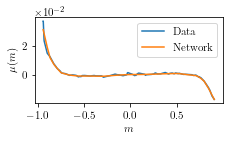

 41%|████      | 2860/7000 [00:12<00:19, 216.09it/s]

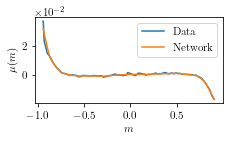

 42%|████▏     | 2960/7000 [00:12<00:18, 220.77it/s]

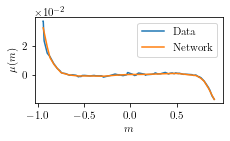

 44%|████▍     | 3063/7000 [00:12<00:17, 224.37it/s]

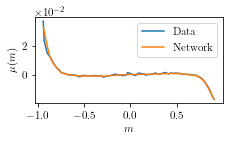

 45%|████▌     | 3163/7000 [00:13<00:16, 227.23it/s]

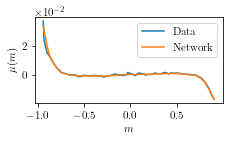

 47%|████▋     | 3263/7000 [00:13<00:16, 228.44it/s]

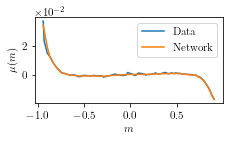

 48%|████▊     | 3356/7000 [00:14<00:16, 222.46it/s]

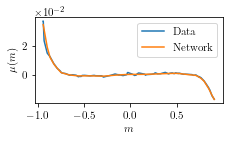

 49%|████▉     | 3462/7000 [00:14<00:16, 216.04it/s]

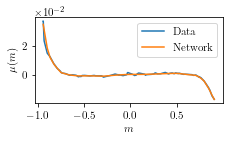

 51%|█████     | 3561/7000 [00:15<00:15, 220.46it/s]

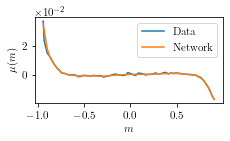

 52%|█████▏    | 3664/7000 [00:15<00:14, 224.90it/s]

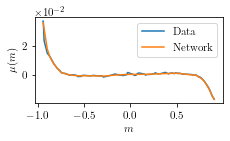

 54%|█████▍    | 3764/7000 [00:16<00:14, 227.46it/s]

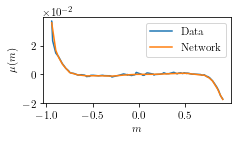

 55%|█████▌    | 3861/7000 [00:16<00:14, 222.79it/s]

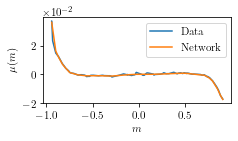

 57%|█████▋    | 3961/7000 [00:16<00:13, 220.95it/s]

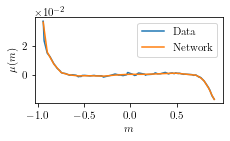

 58%|█████▊    | 4062/7000 [00:17<00:13, 225.41it/s]

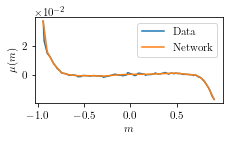

 60%|█████▉    | 4165/7000 [00:17<00:12, 227.50it/s]

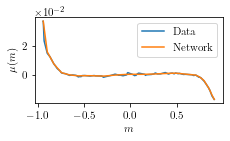

 61%|██████    | 4266/7000 [00:18<00:12, 227.64it/s]

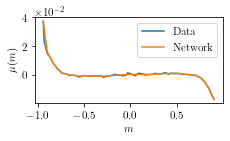

 63%|██████▎   | 4381/7000 [00:19<00:17, 146.83it/s]

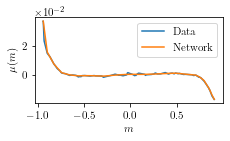

 64%|██████▍   | 4465/7000 [00:20<00:23, 107.62it/s]

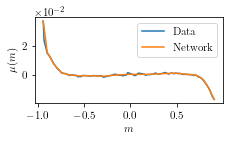

 65%|██████▌   | 4581/7000 [00:21<00:17, 140.79it/s]

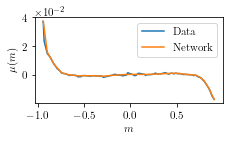

 67%|██████▋   | 4681/7000 [00:22<00:15, 145.92it/s]

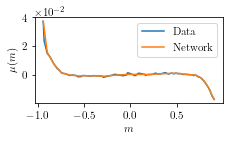

 68%|██████▊   | 4771/7000 [00:23<00:15, 140.10it/s]

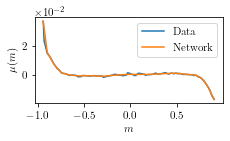

 69%|██████▉   | 4854/7000 [00:23<00:17, 120.14it/s]

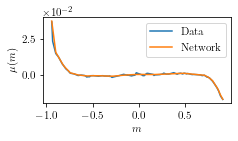

 71%|███████   | 4953/7000 [00:24<00:13, 155.02it/s]

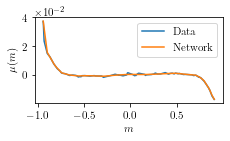

 72%|███████▏  | 5057/7000 [00:24<00:10, 185.38it/s]

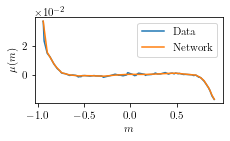

 74%|███████▎  | 5153/7000 [00:25<00:09, 200.30it/s]

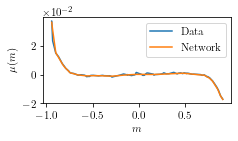

 75%|███████▌  | 5273/7000 [00:25<00:07, 223.33it/s]

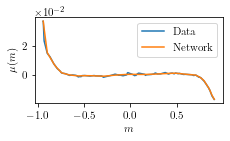

 77%|███████▋  | 5363/7000 [00:26<00:10, 159.88it/s]

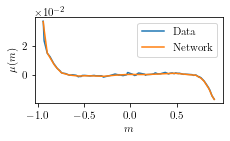

 78%|███████▊  | 5472/7000 [00:26<00:08, 184.28it/s]

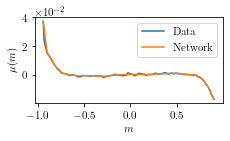

 80%|███████▉  | 5582/7000 [00:27<00:06, 202.73it/s]

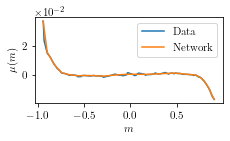

 81%|████████▏ | 5694/7000 [00:27<00:05, 226.29it/s]

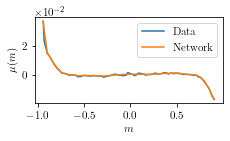

 82%|████████▏ | 5739/7000 [00:28<00:06, 190.28it/s]

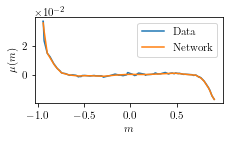

 84%|████████▍ | 5863/7000 [00:28<00:04, 237.42it/s]

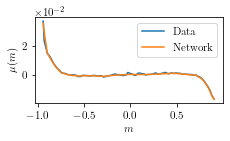

 85%|████████▌ | 5969/7000 [00:28<00:04, 240.32it/s]

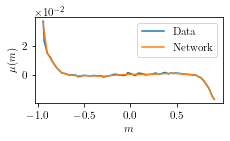

 87%|████████▋ | 6077/7000 [00:29<00:03, 245.51it/s]

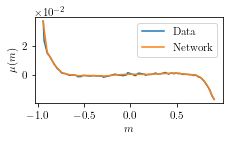

 88%|████████▊ | 6191/7000 [00:29<00:03, 252.23it/s]

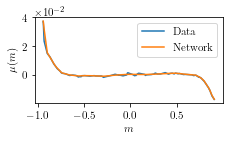

 89%|████████▉ | 6236/7000 [00:30<00:04, 179.50it/s]

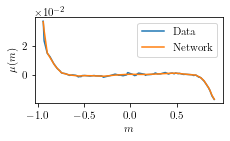

 91%|█████████ | 6353/7000 [00:30<00:02, 222.00it/s]

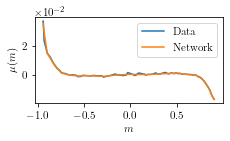

 92%|█████████▏| 6461/7000 [00:31<00:02, 230.52it/s]

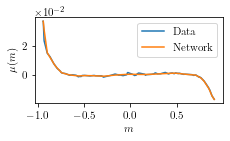

 94%|█████████▎| 6562/7000 [00:31<00:01, 233.47it/s]

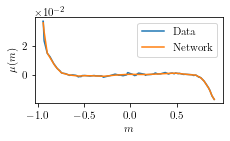

 95%|█████████▌| 6667/7000 [00:31<00:01, 239.32it/s]

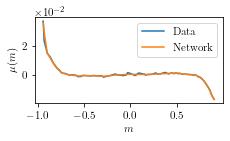

 97%|█████████▋| 6768/7000 [00:32<00:00, 235.45it/s]

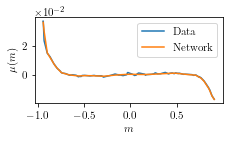

 98%|█████████▊| 6878/7000 [00:32<00:00, 236.54it/s]

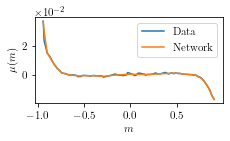

100%|█████████▉| 6992/7000 [00:33<00:00, 245.97it/s]

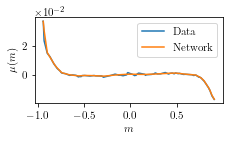

100%|██████████| 7000/7000 [00:33<00:00, 208.78it/s]


Training for model 4


  1%|          | 72/7000 [00:00<00:09, 713.56it/s]

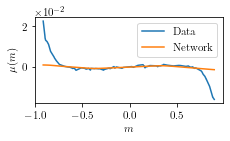

  2%|▏         | 170/7000 [00:00<00:22, 301.26it/s]

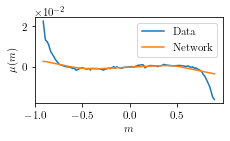

  4%|▍         | 274/7000 [00:00<00:26, 253.16it/s]

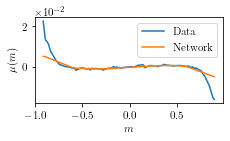

  5%|▌         | 383/7000 [00:01<00:26, 248.88it/s]

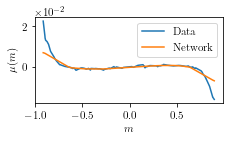

  7%|▋         | 499/7000 [00:01<00:25, 253.77it/s]

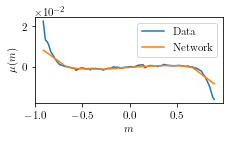

  8%|▊         | 545/7000 [00:02<00:31, 206.26it/s]

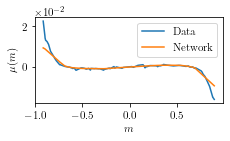

 10%|▉         | 665/7000 [00:02<00:27, 228.86it/s]

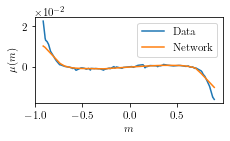

 11%|█         | 772/7000 [00:02<00:26, 234.29it/s]

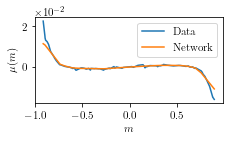

 13%|█▎        | 886/7000 [00:03<00:24, 246.04it/s]

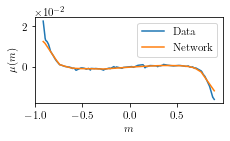

 13%|█▎        | 931/7000 [00:03<00:30, 200.38it/s]

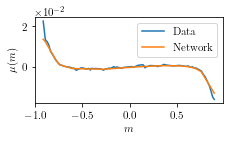

 15%|█▌        | 1063/7000 [00:04<00:23, 251.19it/s]

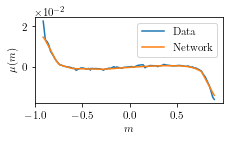

 17%|█▋        | 1167/7000 [00:04<00:23, 249.22it/s]

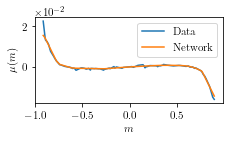

 18%|█▊        | 1277/7000 [00:04<00:22, 251.08it/s]

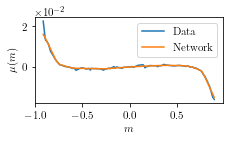

 20%|█▉        | 1392/7000 [00:05<00:21, 255.22it/s]

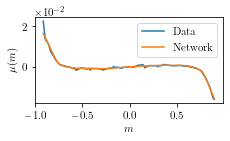

 21%|██        | 1438/7000 [00:05<00:26, 206.14it/s]

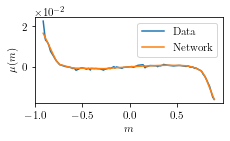

 22%|██▏       | 1559/7000 [00:06<00:21, 248.61it/s]

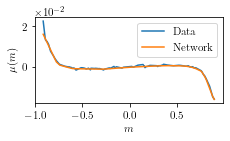

 24%|██▎       | 1661/7000 [00:06<00:21, 247.38it/s]

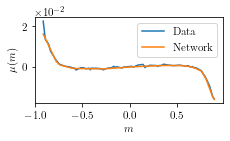

 25%|██▌       | 1766/7000 [00:06<00:21, 247.71it/s]

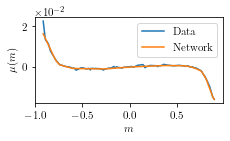

 27%|██▋       | 1871/7000 [00:07<00:20, 244.49it/s]

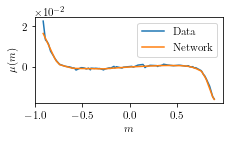

 28%|██▊       | 1982/7000 [00:07<00:20, 247.71it/s]

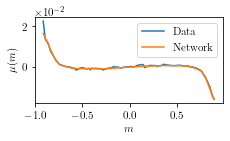

 30%|██▉       | 2098/7000 [00:08<00:20, 235.90it/s]

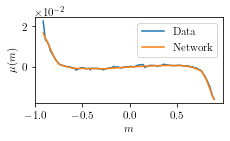

 31%|███       | 2144/7000 [00:08<00:24, 196.74it/s]

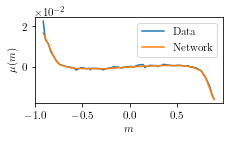

 32%|███▏      | 2262/7000 [00:09<00:19, 237.49it/s]

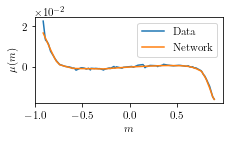

 34%|███▍      | 2366/7000 [00:09<00:19, 238.88it/s]

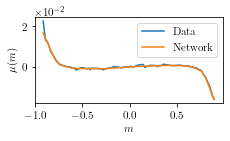

 35%|███▌      | 2478/7000 [00:09<00:18, 246.93it/s]

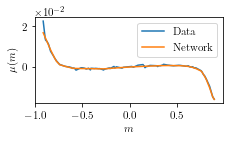

 37%|███▋      | 2592/7000 [00:10<00:17, 253.72it/s]

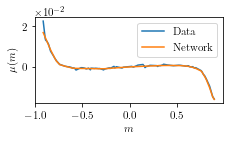

 38%|███▊      | 2638/7000 [00:10<00:21, 204.96it/s]

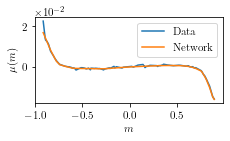

 40%|███▉      | 2770/7000 [00:11<00:16, 253.01it/s]

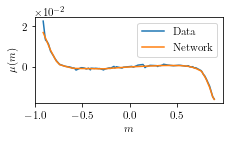

 41%|████      | 2883/7000 [00:11<00:16, 255.23it/s]

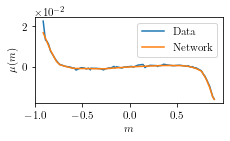

 42%|████▏     | 2928/7000 [00:11<00:19, 204.39it/s]

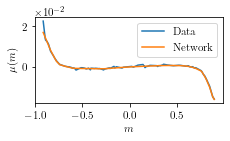

 44%|████▍     | 3072/7000 [00:12<00:15, 260.14it/s]

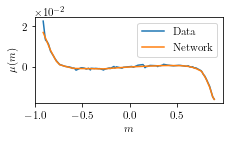

 46%|████▌     | 3188/7000 [00:12<00:14, 258.65it/s]

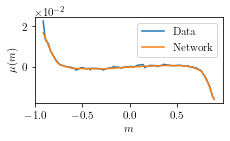

 46%|████▌     | 3234/7000 [00:13<00:18, 207.49it/s]

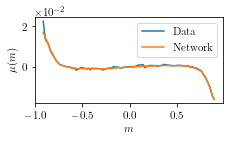

 48%|████▊     | 3370/7000 [00:13<00:14, 258.15it/s]

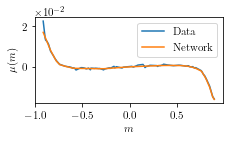

 50%|████▉     | 3478/7000 [00:13<00:14, 235.26it/s]

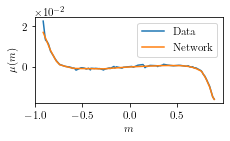

 51%|█████▏    | 3590/7000 [00:14<00:14, 237.67it/s]

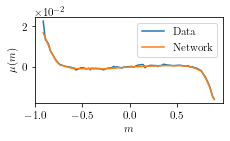

 53%|█████▎    | 3688/7000 [00:14<00:15, 212.70it/s]

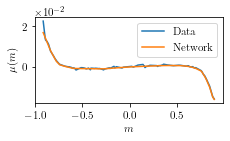

 54%|█████▍    | 3797/7000 [00:15<00:15, 207.33it/s]

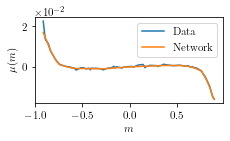

 55%|█████▌    | 3871/7000 [00:16<00:17, 175.04it/s]

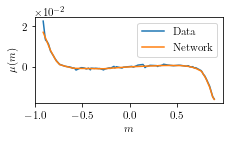

 56%|█████▋    | 3948/7000 [00:16<00:19, 158.13it/s]

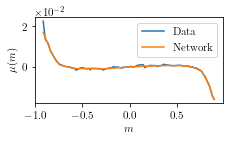

 58%|█████▊    | 4094/7000 [00:17<00:13, 220.01it/s]

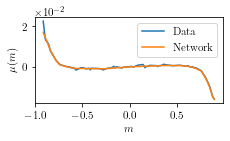

 60%|█████▉    | 4177/7000 [00:17<00:15, 185.09it/s]

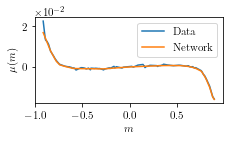

 61%|██████    | 4260/7000 [00:18<00:15, 172.43it/s]

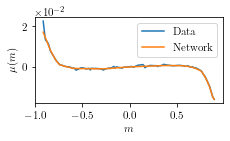

 63%|██████▎   | 4395/7000 [00:18<00:12, 214.62it/s]

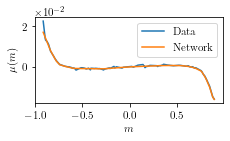

 64%|██████▍   | 4482/7000 [00:19<00:13, 193.21it/s]

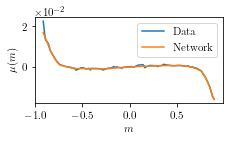

 65%|██████▌   | 4564/7000 [00:20<00:14, 170.30it/s]

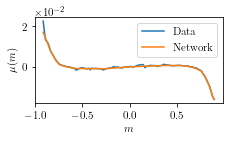

 66%|██████▋   | 4650/7000 [00:20<00:13, 172.89it/s]

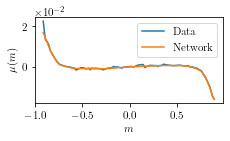

 68%|██████▊   | 4760/7000 [00:21<00:11, 199.06it/s]

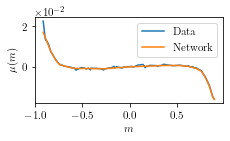

 70%|██████▉   | 4887/7000 [00:21<00:10, 195.20it/s]

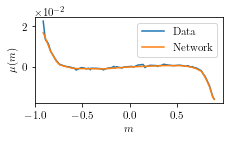

 71%|███████   | 4978/7000 [00:22<00:10, 198.50it/s]

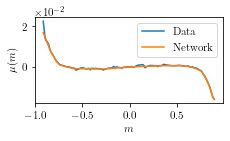

 72%|███████▏  | 5059/7000 [00:22<00:10, 187.57it/s]

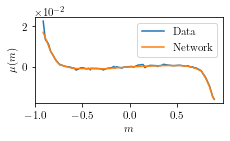

 74%|███████▎  | 5154/7000 [00:23<00:09, 188.71it/s]

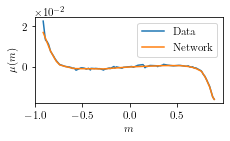

 76%|███████▌  | 5294/7000 [00:23<00:06, 246.16it/s]

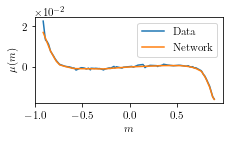

 77%|███████▋  | 5392/7000 [00:24<00:07, 219.34it/s]

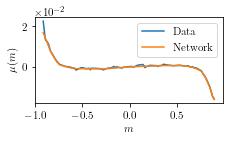

 78%|███████▊  | 5493/7000 [00:24<00:07, 195.05it/s]

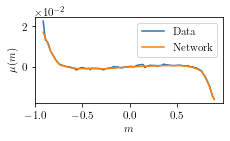

 80%|███████▉  | 5596/7000 [00:25<00:07, 189.44it/s]

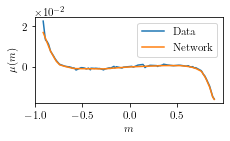

 81%|████████  | 5636/7000 [00:25<00:08, 152.98it/s]

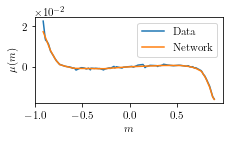

 82%|████████▏ | 5769/7000 [00:26<00:05, 208.21it/s]

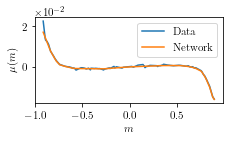

 84%|████████▎ | 5860/7000 [00:26<00:05, 200.96it/s]

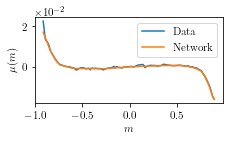

 85%|████████▌ | 5959/7000 [00:27<00:05, 206.27it/s]

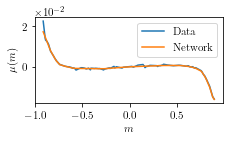

 87%|████████▋ | 6063/7000 [00:27<00:04, 223.14it/s]

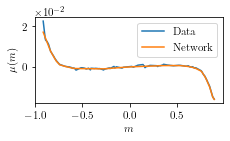

 88%|████████▊ | 6136/7000 [00:28<00:04, 188.17it/s]

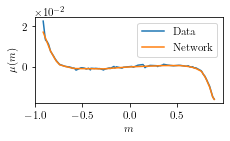

 90%|████████▉ | 6297/7000 [00:28<00:02, 253.13it/s]

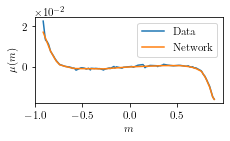

 91%|█████████▏| 6399/7000 [00:29<00:02, 215.57it/s]

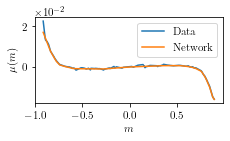

 93%|█████████▎| 6490/7000 [00:29<00:02, 217.34it/s]

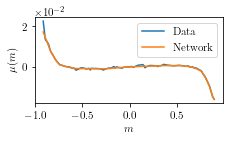

 94%|█████████▍| 6593/7000 [00:30<00:01, 214.25it/s]

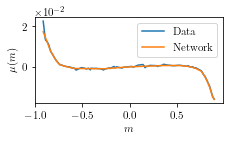

 96%|█████████▌| 6696/7000 [00:30<00:01, 200.79it/s]

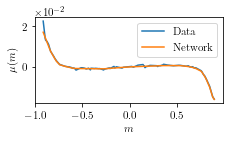

 97%|█████████▋| 6795/7000 [00:31<00:00, 208.79it/s]

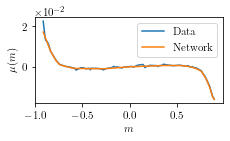

 98%|█████████▊| 6882/7000 [00:31<00:00, 190.14it/s]

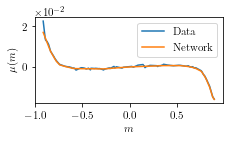

100%|█████████▉| 6998/7000 [00:32<00:00, 200.48it/s]

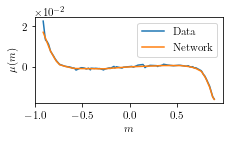

100%|██████████| 7000/7000 [00:32<00:00, 213.76it/s]


Training for model 5


  1%|          | 68/7000 [00:00<00:10, 672.16it/s]

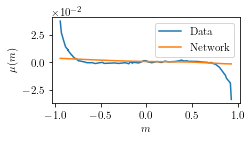

  3%|▎         | 195/7000 [00:00<00:21, 320.07it/s]

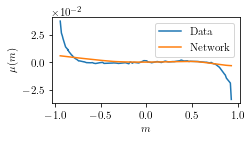

  4%|▍         | 283/7000 [00:01<00:29, 224.14it/s]

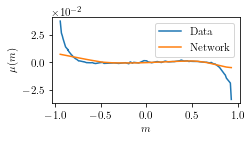

  5%|▌         | 382/7000 [00:01<00:34, 193.87it/s]

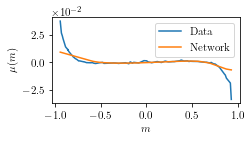

  7%|▋         | 485/7000 [00:02<00:35, 186.11it/s]

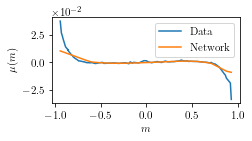

  8%|▊         | 588/7000 [00:02<00:34, 185.69it/s]

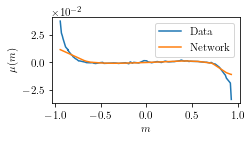

 10%|▉         | 670/7000 [00:03<00:36, 174.28it/s]

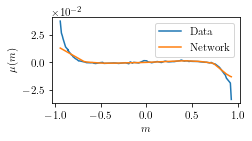

 11%|█         | 746/7000 [00:03<00:38, 161.99it/s]

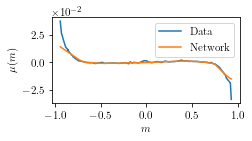

 12%|█▏        | 861/7000 [00:04<00:30, 200.15it/s]

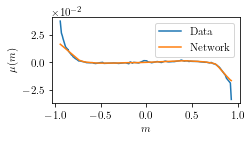

 14%|█▍        | 965/7000 [00:04<00:29, 203.14it/s]

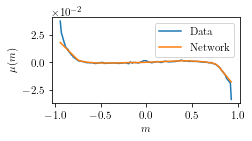

 15%|█▌        | 1071/7000 [00:05<00:27, 215.38it/s]

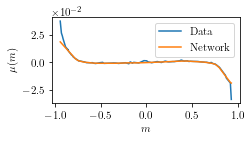

 17%|█▋        | 1159/7000 [00:05<00:28, 205.69it/s]

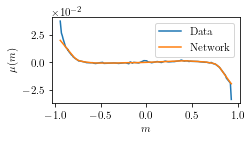

 18%|█▊        | 1266/7000 [00:06<00:27, 210.56it/s]

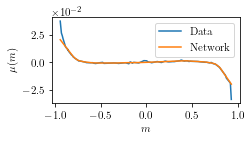

 20%|█▉        | 1369/7000 [00:06<00:27, 203.64it/s]

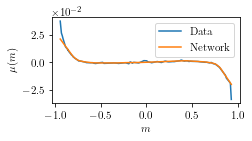

 21%|██▏       | 1496/7000 [00:07<00:24, 225.05it/s]

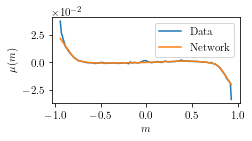

 23%|██▎       | 1586/7000 [00:07<00:28, 192.45it/s]

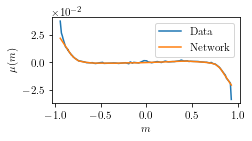

 24%|██▍       | 1666/7000 [00:08<00:29, 181.47it/s]

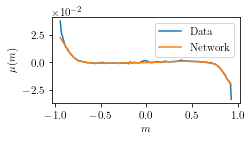

 25%|██▌       | 1762/7000 [00:08<00:29, 177.88it/s]

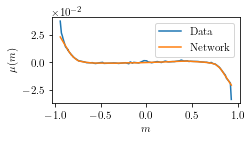

 27%|██▋       | 1891/7000 [00:09<00:23, 219.15it/s]

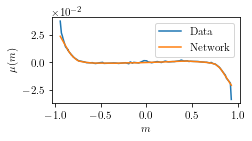

 28%|██▊       | 1979/7000 [00:09<00:25, 193.31it/s]

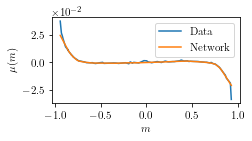

 30%|██▉       | 2065/7000 [00:10<00:28, 171.89it/s]

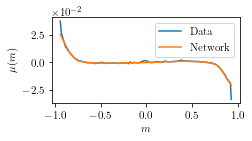

 31%|███       | 2155/7000 [00:10<00:27, 173.38it/s]

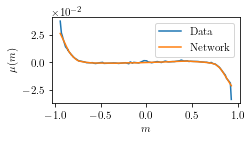

 32%|███▏      | 2250/7000 [00:11<00:24, 190.31it/s]

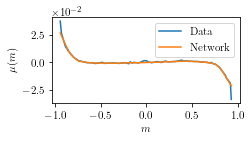

 34%|███▎      | 2355/7000 [00:11<00:22, 209.07it/s]

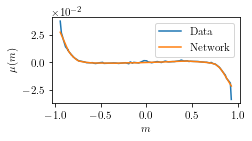

 35%|███▍      | 2448/7000 [00:12<00:22, 202.83it/s]

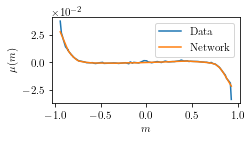

 37%|███▋      | 2563/7000 [00:12<00:20, 217.12it/s]

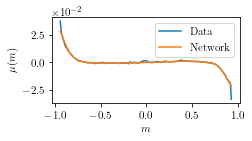

 38%|███▊      | 2655/7000 [00:13<00:21, 199.57it/s]

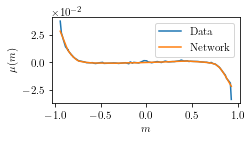

 39%|███▉      | 2763/7000 [00:13<00:20, 211.16it/s]

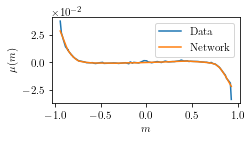

 41%|████      | 2862/7000 [00:14<00:20, 199.24it/s]

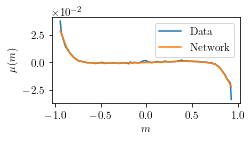

 42%|████▏     | 2953/7000 [00:15<00:21, 186.35it/s]

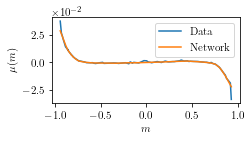

 44%|████▎     | 3054/7000 [00:15<00:19, 200.04it/s]

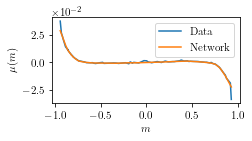

 46%|████▌     | 3188/7000 [00:16<00:15, 247.62it/s]

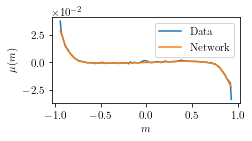

 47%|████▋     | 3288/7000 [00:16<00:20, 181.28it/s]

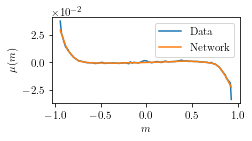

 48%|████▊     | 3393/7000 [00:17<00:18, 192.93it/s]

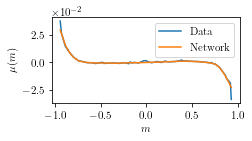

 49%|████▉     | 3434/7000 [00:17<00:22, 155.46it/s]

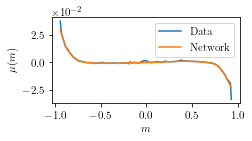

 51%|█████     | 3557/7000 [00:18<00:16, 206.41it/s]

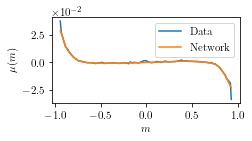

 52%|█████▏    | 3657/7000 [00:18<00:15, 216.43it/s]

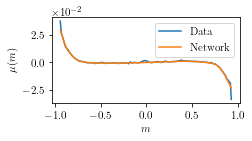

 54%|█████▎    | 3757/7000 [00:18<00:14, 225.75it/s]

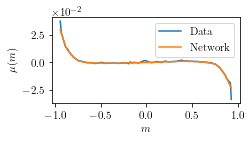

 55%|█████▌    | 3864/7000 [00:19<00:13, 233.25it/s]

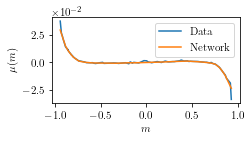

 57%|█████▋    | 3969/7000 [00:19<00:13, 233.05it/s]

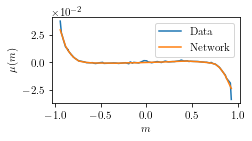

 58%|█████▊    | 4076/7000 [00:20<00:12, 235.71it/s]

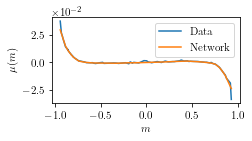

 60%|█████▉    | 4190/7000 [00:20<00:11, 239.55it/s]

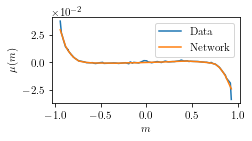

 60%|██████    | 4235/7000 [00:21<00:14, 189.52it/s]

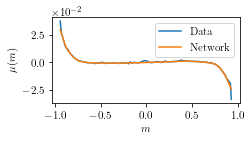

 62%|██████▏   | 4368/7000 [00:21<00:11, 237.32it/s]

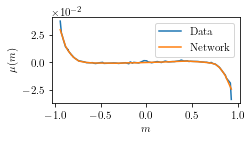

 64%|██████▍   | 4474/7000 [00:21<00:10, 237.09it/s]

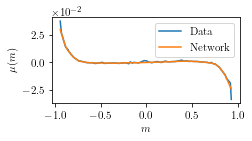

 65%|██████▌   | 4576/7000 [00:22<00:11, 203.66it/s]

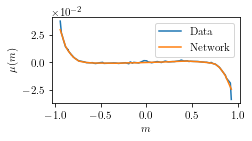

 67%|██████▋   | 4667/7000 [00:22<00:11, 200.77it/s]

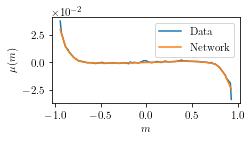

 68%|██████▊   | 4752/7000 [00:23<00:11, 187.89it/s]

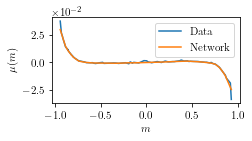

 70%|██████▉   | 4868/7000 [00:24<00:10, 199.33it/s]

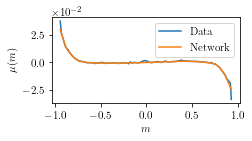

 71%|███████   | 4970/7000 [00:24<00:09, 203.12it/s]

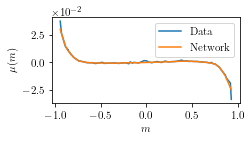

 72%|███████▏  | 5074/7000 [00:25<00:09, 199.26it/s]

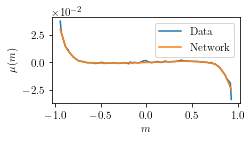

 74%|███████▎  | 5157/7000 [00:25<00:09, 188.36it/s]

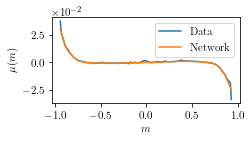

 76%|███████▌  | 5299/7000 [00:26<00:07, 236.20it/s]

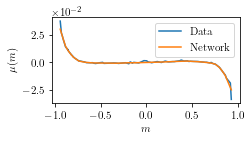

 77%|███████▋  | 5397/7000 [00:26<00:07, 208.49it/s]

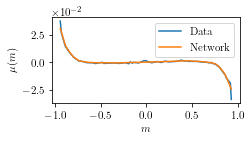

 78%|███████▊  | 5491/7000 [00:27<00:07, 205.40it/s]

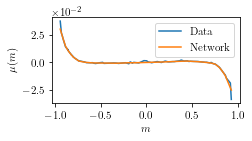

 80%|███████▉  | 5586/7000 [00:27<00:07, 182.98it/s]

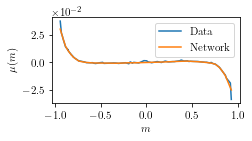

 81%|████████  | 5672/7000 [00:28<00:07, 180.59it/s]

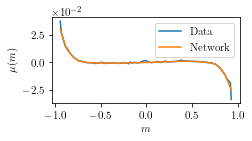

 82%|████████▏ | 5750/7000 [00:28<00:06, 181.05it/s]

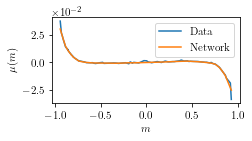

 84%|████████▎ | 5852/7000 [00:29<00:05, 194.49it/s]

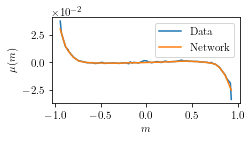

 85%|████████▌ | 5954/7000 [00:29<00:05, 200.29it/s]

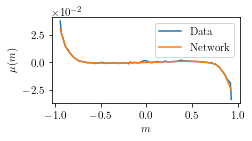

 87%|████████▋ | 6059/7000 [00:30<00:04, 210.28it/s]

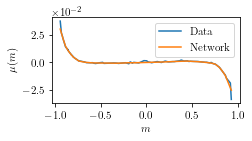

 88%|████████▊ | 6154/7000 [00:30<00:04, 200.12it/s]

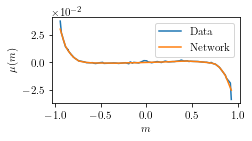

 89%|████████▉ | 6261/7000 [00:31<00:03, 209.10it/s]

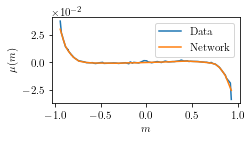

 91%|█████████ | 6359/7000 [00:31<00:02, 215.51it/s]

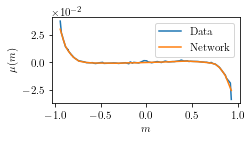

 92%|█████████▏| 6467/7000 [00:32<00:02, 225.42it/s]

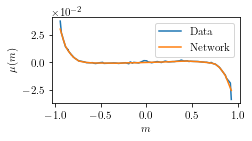

 94%|█████████▍| 6574/7000 [00:32<00:01, 230.39it/s]

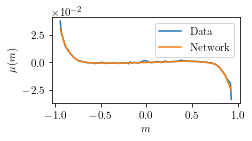

 95%|█████████▌| 6683/7000 [00:32<00:01, 235.12it/s]

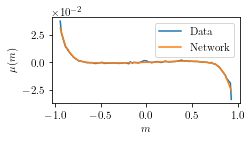

 97%|█████████▋| 6793/7000 [00:33<00:00, 237.31it/s]

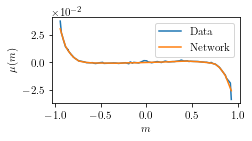

 98%|█████████▊| 6837/7000 [00:33<00:00, 189.23it/s]

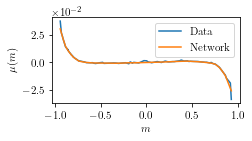

 99%|█████████▉| 6963/7000 [00:34<00:00, 234.53it/s]

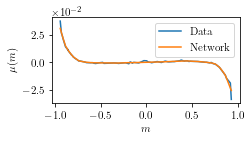

100%|██████████| 7000/7000 [00:34<00:00, 202.88it/s]


Training for model 6


  1%|          | 71/7000 [00:00<00:09, 709.67it/s]

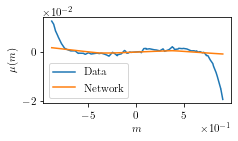

  2%|▏         | 168/7000 [00:00<00:26, 262.35it/s]

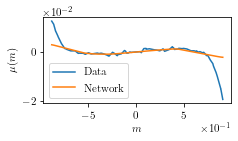

  4%|▍         | 267/7000 [00:00<00:29, 231.26it/s]

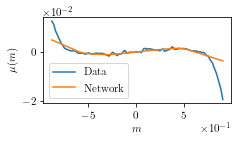

  5%|▍         | 342/7000 [00:01<00:31, 214.51it/s]

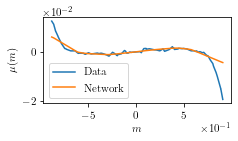

  7%|▋         | 464/7000 [00:01<00:25, 251.95it/s]

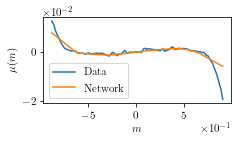

  8%|▊         | 568/7000 [00:02<00:26, 242.28it/s]

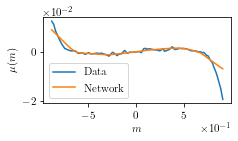

 10%|▉         | 678/7000 [00:02<00:25, 243.87it/s]

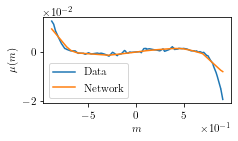

 11%|█▏        | 788/7000 [00:03<00:25, 248.03it/s]

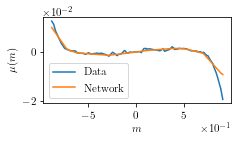

 12%|█▏        | 832/7000 [00:03<00:31, 198.52it/s]

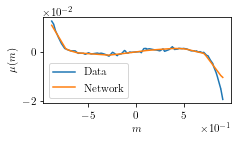

 14%|█▍        | 970/7000 [00:03<00:23, 251.58it/s]

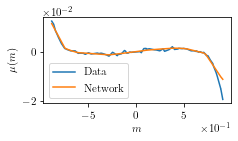

 15%|█▌        | 1082/7000 [00:04<00:23, 250.77it/s]

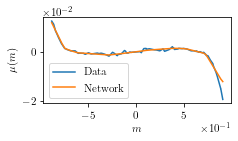

 17%|█▋        | 1197/7000 [00:04<00:22, 253.86it/s]

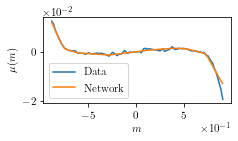

 18%|█▊        | 1243/7000 [00:05<00:28, 204.37it/s]

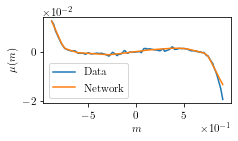

 20%|█▉        | 1372/7000 [00:05<00:22, 247.04it/s]

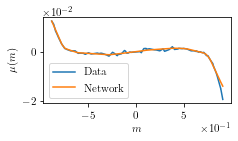

 21%|██        | 1481/7000 [00:05<00:22, 249.04it/s]

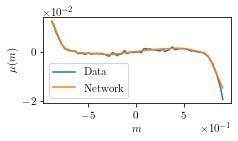

 23%|██▎       | 1596/7000 [00:06<00:23, 234.03it/s]

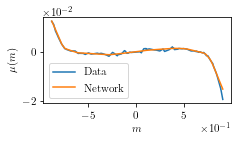

 23%|██▎       | 1641/7000 [00:06<00:27, 192.12it/s]

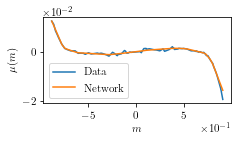

 25%|██▌       | 1765/7000 [00:07<00:22, 237.79it/s]

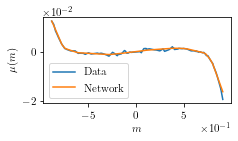

 27%|██▋       | 1873/7000 [00:07<00:21, 240.69it/s]

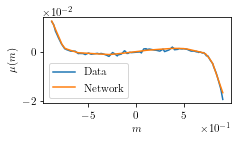

 28%|██▊       | 1987/7000 [00:08<00:20, 247.40it/s]

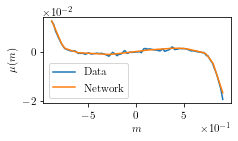

 30%|██▉       | 2096/7000 [00:08<00:19, 249.49it/s]

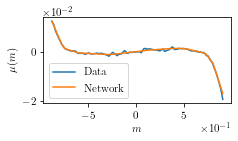

 31%|███▏      | 2190/7000 [00:08<00:20, 233.54it/s]

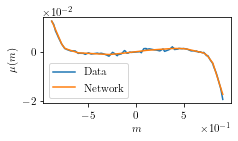

 32%|███▏      | 2273/7000 [00:09<00:22, 207.21it/s]

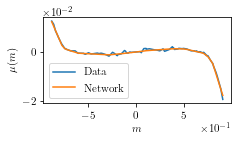

 34%|███▍      | 2394/7000 [00:10<00:21, 210.19it/s]

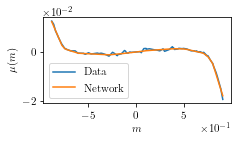

 35%|███▌      | 2473/7000 [00:10<00:26, 172.58it/s]

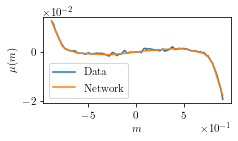

 37%|███▋      | 2598/7000 [00:11<00:22, 193.91it/s]

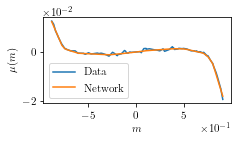

 38%|███▊      | 2673/7000 [00:11<00:25, 167.75it/s]

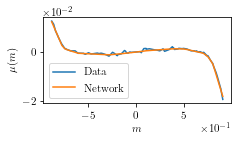

 40%|███▉      | 2786/7000 [00:12<00:22, 187.69it/s]

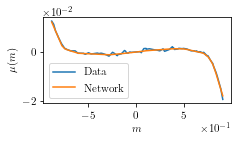

 41%|████      | 2867/7000 [00:12<00:24, 169.70it/s]

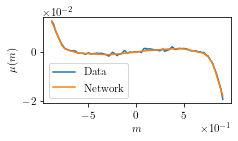

 43%|████▎     | 2979/7000 [00:13<00:26, 150.56it/s]

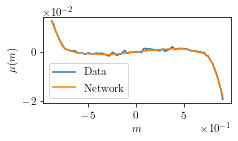

 44%|████▍     | 3076/7000 [00:14<00:25, 156.02it/s]

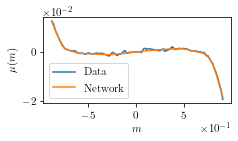

 45%|████▌     | 3163/7000 [00:15<00:25, 148.40it/s]

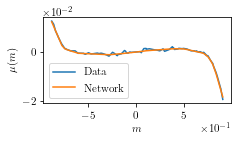

 47%|████▋     | 3269/7000 [00:15<00:19, 187.47it/s]

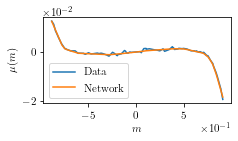

 48%|████▊     | 3385/7000 [00:16<00:18, 193.39it/s]

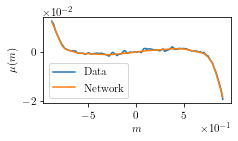

 49%|████▉     | 3457/7000 [00:17<00:23, 153.75it/s]

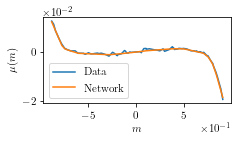

 51%|█████     | 3571/7000 [00:17<00:19, 179.29it/s]

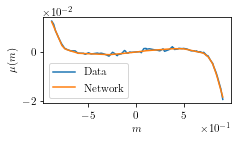

 53%|█████▎    | 3688/7000 [00:18<00:17, 185.52it/s]

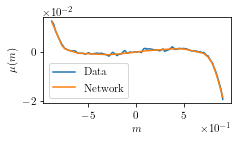

 54%|█████▍    | 3766/7000 [00:19<00:22, 142.53it/s]

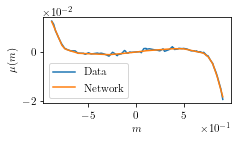

 55%|█████▌    | 3850/7000 [00:19<00:21, 149.63it/s]

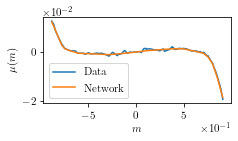

 57%|█████▋    | 3964/7000 [00:20<00:16, 184.90it/s]

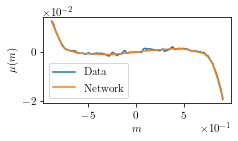

 58%|█████▊    | 4084/7000 [00:20<00:14, 199.64it/s]

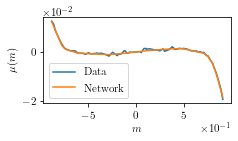

 60%|█████▉    | 4171/7000 [00:21<00:15, 184.24it/s]

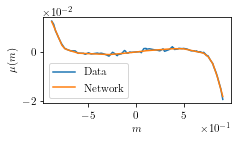

 61%|██████▏   | 4296/7000 [00:21<00:13, 206.25it/s]

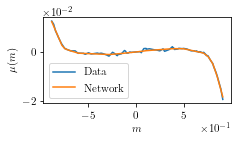

 63%|██████▎   | 4396/7000 [00:22<00:14, 182.62it/s]

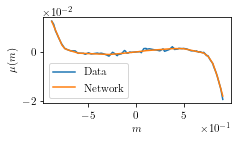

 64%|██████▍   | 4482/7000 [00:22<00:13, 188.51it/s]

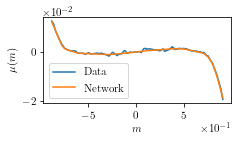

 65%|██████▌   | 4579/7000 [00:23<00:12, 191.51it/s]

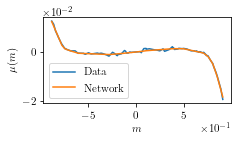

 67%|██████▋   | 4662/7000 [00:23<00:13, 168.94it/s]

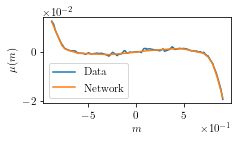

 68%|██████▊   | 4786/7000 [00:24<00:10, 212.70it/s]

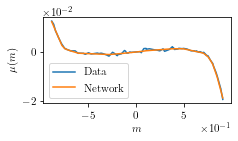

 69%|██████▉   | 4864/7000 [00:25<00:11, 193.30it/s]

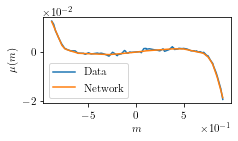

 71%|███████▏  | 4995/7000 [00:25<00:08, 226.10it/s]

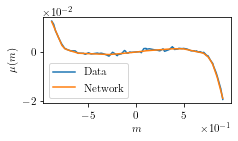

 73%|███████▎  | 5094/7000 [00:26<00:09, 193.32it/s]

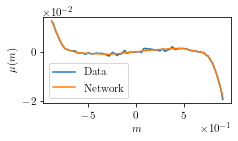

 74%|███████▍  | 5197/7000 [00:26<00:09, 189.92it/s]

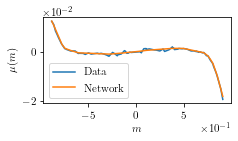

 76%|███████▌  | 5291/7000 [00:27<00:08, 203.61it/s]

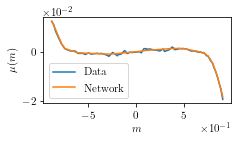

 77%|███████▋  | 5394/7000 [00:27<00:08, 194.44it/s]

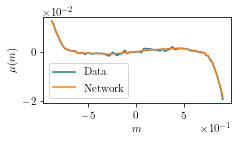

 78%|███████▊  | 5492/7000 [00:28<00:07, 189.52it/s]

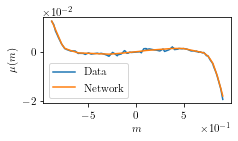

 80%|███████▉  | 5594/7000 [00:28<00:07, 188.88it/s]

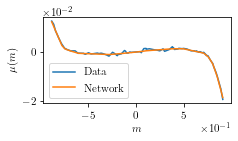

 81%|████████  | 5684/7000 [00:29<00:06, 194.10it/s]

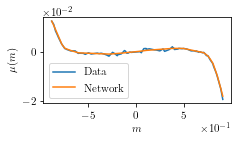

 82%|████████▏ | 5766/7000 [00:29<00:07, 172.45it/s]

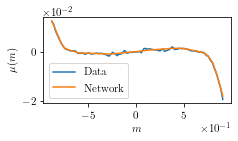

 84%|████████▎ | 5860/7000 [00:30<00:06, 179.24it/s]

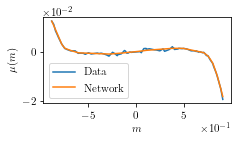

 85%|████████▌ | 5977/7000 [00:30<00:04, 216.91it/s]

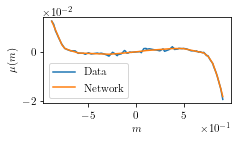

 87%|████████▋ | 6072/7000 [00:31<00:04, 206.99it/s]

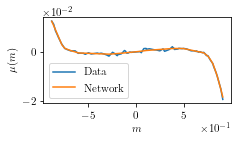

 88%|████████▊ | 6149/7000 [00:31<00:04, 187.01it/s]

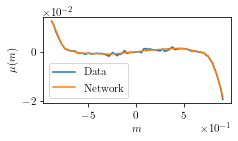

 89%|████████▉ | 6261/7000 [00:32<00:03, 218.89it/s]

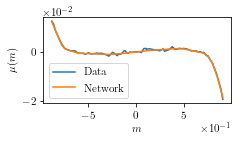

 91%|█████████ | 6383/7000 [00:32<00:02, 239.26it/s]

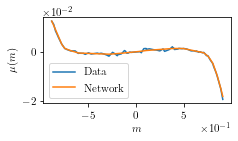

 92%|█████████▏| 6466/7000 [00:33<00:02, 212.05it/s]

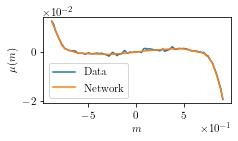

 94%|█████████▎| 6560/7000 [00:33<00:02, 184.27it/s]

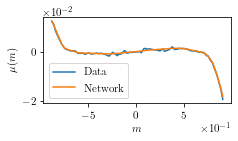

 96%|█████████▌| 6696/7000 [00:34<00:01, 238.60it/s]

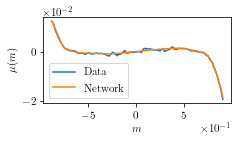

 97%|█████████▋| 6780/7000 [00:34<00:01, 195.66it/s]

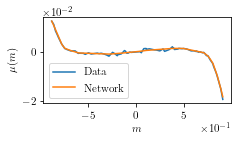

 98%|█████████▊| 6855/7000 [00:35<00:00, 175.18it/s]

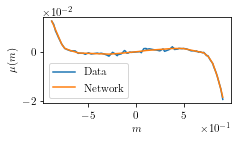

100%|█████████▉| 6985/7000 [00:35<00:00, 213.24it/s]

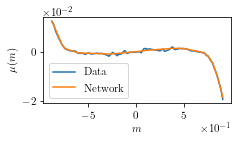

100%|██████████| 7000/7000 [00:36<00:00, 193.16it/s]


Training for model 7


  1%|          | 60/7000 [00:00<00:11, 597.66it/s]

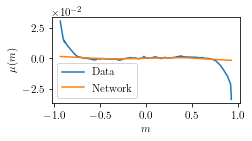

  3%|▎         | 199/7000 [00:01<00:28, 235.88it/s]

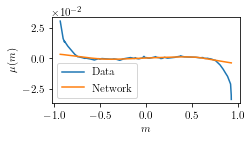

  4%|▍         | 282/7000 [00:01<00:47, 141.51it/s]

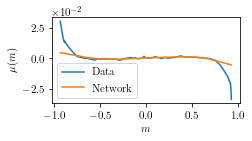

  6%|▌         | 387/7000 [00:02<00:39, 165.49it/s]

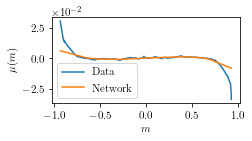

  6%|▌         | 426/7000 [00:02<00:44, 148.08it/s]

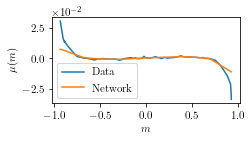

  8%|▊         | 576/7000 [00:02<00:30, 209.49it/s]

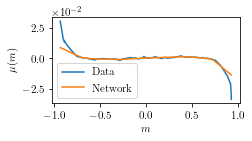

 10%|▉         | 691/7000 [00:03<00:27, 226.85it/s]

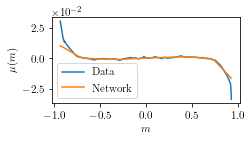

 11%|█         | 736/7000 [00:03<00:33, 186.15it/s]

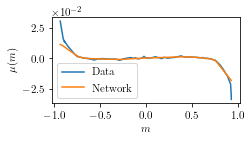

 12%|█▏        | 871/7000 [00:04<00:26, 229.37it/s]

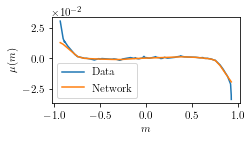

 14%|█▍        | 985/7000 [00:04<00:25, 238.23it/s]

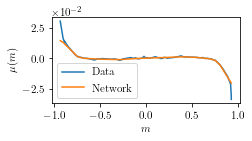

 15%|█▍        | 1030/7000 [00:05<00:30, 193.44it/s]

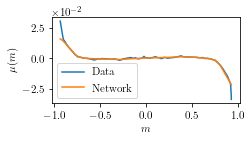

 17%|█▋        | 1174/7000 [00:05<00:23, 247.30it/s]

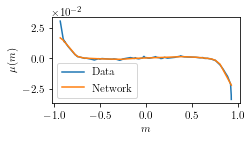

 18%|█▊        | 1288/7000 [00:05<00:22, 250.34it/s]

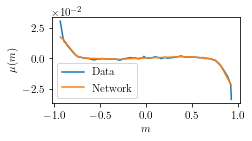

 19%|█▉        | 1333/7000 [00:06<00:29, 189.10it/s]

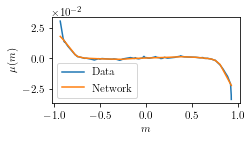

 21%|██        | 1473/7000 [00:06<00:24, 228.82it/s]

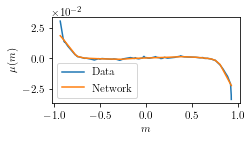

 23%|██▎       | 1592/7000 [00:07<00:22, 238.82it/s]

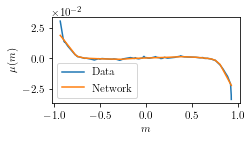

 23%|██▎       | 1639/7000 [00:07<00:27, 197.75it/s]

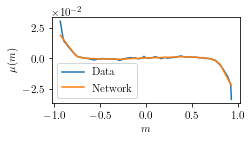

 25%|██▌       | 1774/7000 [00:08<00:21, 244.04it/s]

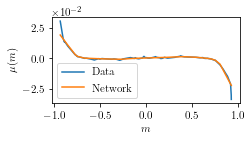

 27%|██▋       | 1895/7000 [00:08<00:20, 252.42it/s]

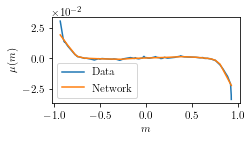

 28%|██▊       | 1943/7000 [00:08<00:25, 196.57it/s]

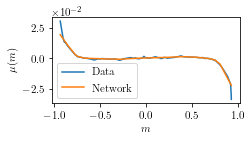

 30%|██▉       | 2071/7000 [00:09<00:20, 237.82it/s]

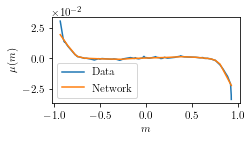

 31%|███       | 2185/7000 [00:09<00:20, 239.04it/s]

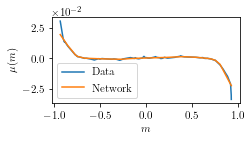

 32%|███▏      | 2230/7000 [00:10<00:24, 193.89it/s]

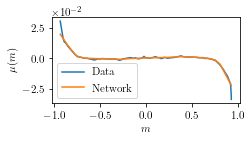

 34%|███▍      | 2372/7000 [00:10<00:18, 247.01it/s]

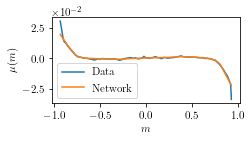

 36%|███▌      | 2491/7000 [00:10<00:18, 249.71it/s]

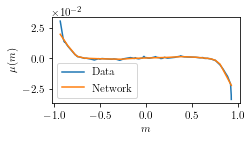

 36%|███▋      | 2538/7000 [00:11<00:23, 185.94it/s]

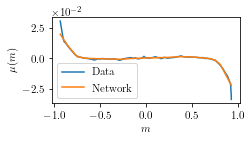

 38%|███▊      | 2675/7000 [00:11<00:18, 235.80it/s]

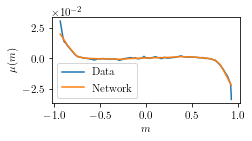

 40%|███▉      | 2788/7000 [00:12<00:19, 214.62it/s]

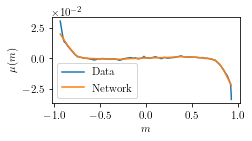

 40%|████      | 2833/7000 [00:12<00:22, 182.68it/s]

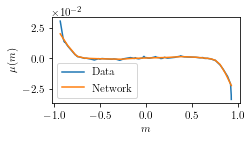

 42%|████▏     | 2964/7000 [00:13<00:17, 233.96it/s]

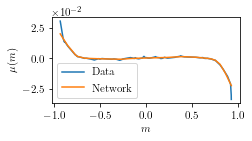

 44%|████▍     | 3072/7000 [00:13<00:16, 236.93it/s]

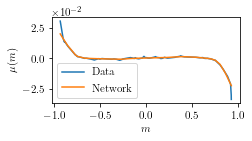

 46%|████▌     | 3185/7000 [00:14<00:15, 239.51it/s]

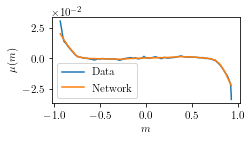

 46%|████▌     | 3230/7000 [00:14<00:19, 193.64it/s]

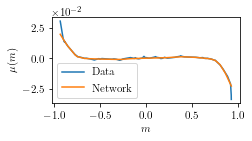

 48%|████▊     | 3374/7000 [00:14<00:14, 247.86it/s]

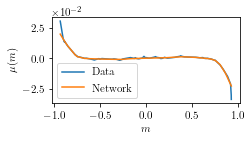

 50%|████▉     | 3495/7000 [00:15<00:13, 254.10it/s]

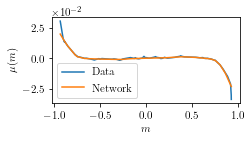

 51%|█████     | 3542/7000 [00:15<00:16, 204.37it/s]

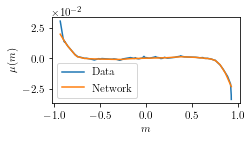

 52%|█████▏    | 3672/7000 [00:16<00:14, 235.42it/s]

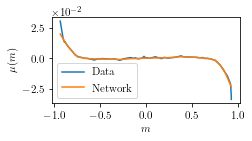

 54%|█████▍    | 3789/7000 [00:16<00:13, 243.79it/s]

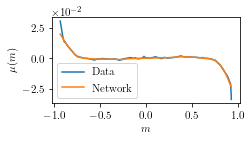

 55%|█████▍    | 3835/7000 [00:16<00:16, 193.20it/s]

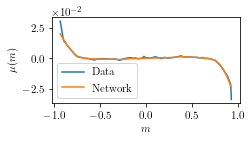

 57%|█████▋    | 3976/7000 [00:17<00:12, 242.47it/s]

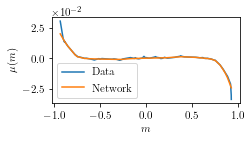

 59%|█████▊    | 4097/7000 [00:17<00:12, 232.28it/s]

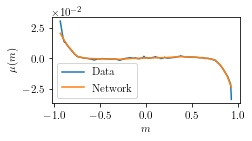

 59%|█████▉    | 4144/7000 [00:18<00:14, 193.63it/s]

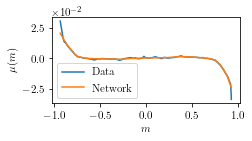

 61%|██████    | 4271/7000 [00:18<00:12, 226.94it/s]

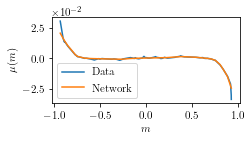

 63%|██████▎   | 4388/7000 [00:19<00:10, 237.61it/s]

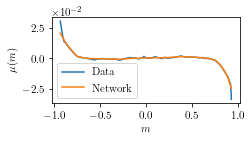

 63%|██████▎   | 4434/7000 [00:19<00:13, 194.87it/s]

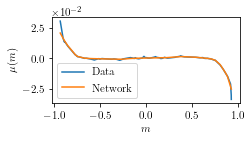

 65%|██████▌   | 4573/7000 [00:19<00:09, 244.65it/s]

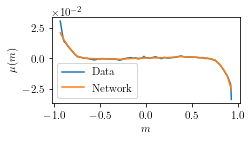

 67%|██████▋   | 4690/7000 [00:20<00:09, 249.74it/s]

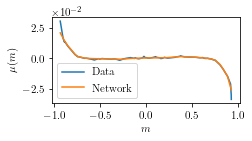

 68%|██████▊   | 4736/7000 [00:20<00:11, 199.94it/s]

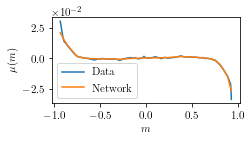

 70%|██████▉   | 4873/7000 [00:21<00:08, 239.98it/s]

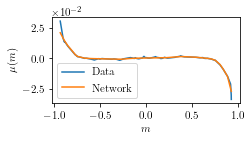

 71%|███████▏  | 4992/7000 [00:21<00:08, 246.08it/s]

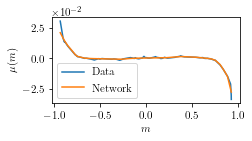

 72%|███████▏  | 5039/7000 [00:21<00:09, 201.36it/s]

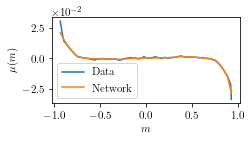

 74%|███████▍  | 5173/7000 [00:22<00:07, 246.25it/s]

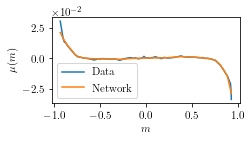

 76%|███████▌  | 5291/7000 [00:22<00:06, 251.39it/s]

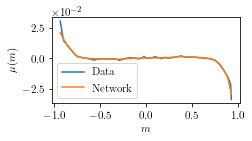

 76%|███████▋  | 5338/7000 [00:23<00:08, 187.30it/s]

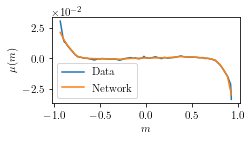

 78%|███████▊  | 5474/7000 [00:23<00:06, 230.02it/s]

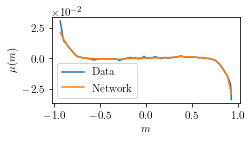

 80%|███████▉  | 5593/7000 [00:24<00:05, 240.37it/s]

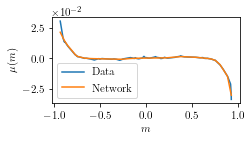

 81%|████████  | 5640/7000 [00:24<00:06, 198.36it/s]

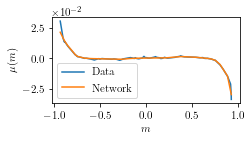

 82%|████████▏ | 5771/7000 [00:24<00:05, 241.49it/s]

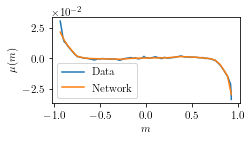

 84%|████████▍ | 5891/7000 [00:25<00:04, 247.50it/s]

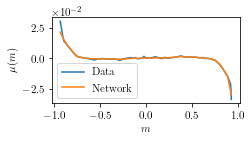

 85%|████████▍ | 5938/7000 [00:25<00:05, 202.35it/s]

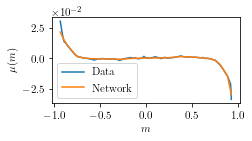

 87%|████████▋ | 6075/7000 [00:26<00:03, 246.42it/s]

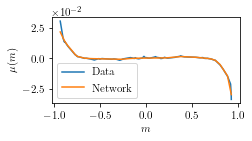

 88%|████████▊ | 6190/7000 [00:26<00:03, 251.32it/s]

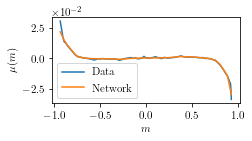

 89%|████████▉ | 6236/7000 [00:26<00:03, 201.93it/s]

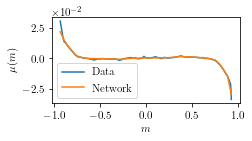

 91%|█████████ | 6370/7000 [00:27<00:02, 248.01it/s]

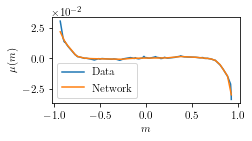

 93%|█████████▎| 6485/7000 [00:27<00:02, 248.24it/s]

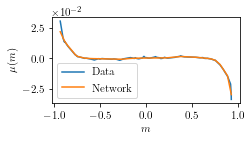

 93%|█████████▎| 6530/7000 [00:28<00:02, 188.98it/s]

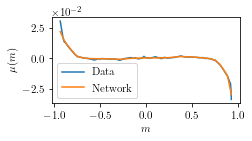

 95%|█████████▌| 6670/7000 [00:28<00:01, 231.11it/s]

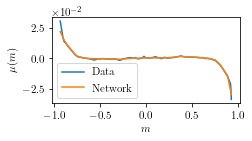

 97%|█████████▋| 6785/7000 [00:29<00:00, 238.98it/s]

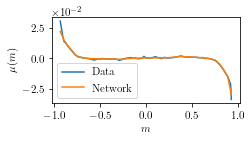

 98%|█████████▊| 6830/7000 [00:29<00:00, 194.79it/s]

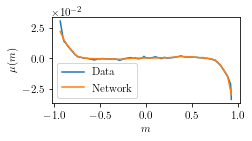

100%|█████████▉| 6972/7000 [00:29<00:00, 247.74it/s]

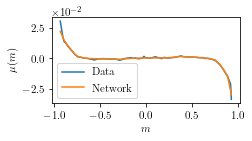

100%|██████████| 7000/7000 [00:30<00:00, 231.09it/s]


Training for model 8


  1%|          | 76/7000 [00:00<00:09, 756.00it/s]

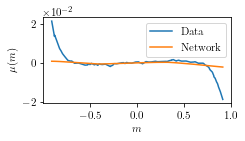

  3%|▎         | 178/7000 [00:00<00:26, 254.89it/s]

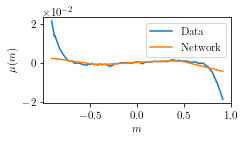

  4%|▍         | 291/7000 [00:00<00:27, 243.14it/s]

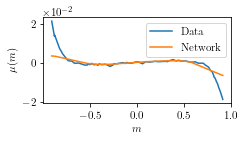

  5%|▍         | 334/7000 [00:01<00:33, 196.96it/s]

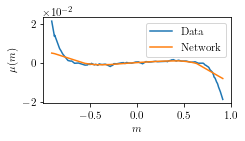

  7%|▋         | 478/7000 [00:01<00:25, 251.53it/s]

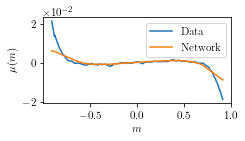

  8%|▊         | 594/7000 [00:02<00:24, 259.46it/s]

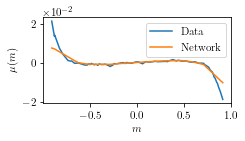

  9%|▉         | 641/7000 [00:02<00:30, 207.18it/s]

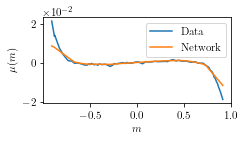

 11%|█         | 776/7000 [00:02<00:25, 244.57it/s]

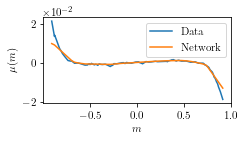

 13%|█▎        | 897/7000 [00:03<00:23, 257.17it/s]

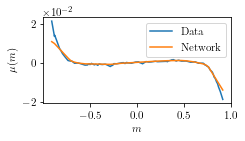

 14%|█▎        | 945/7000 [00:03<00:28, 212.15it/s]

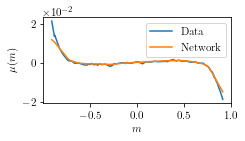

 15%|█▌        | 1074/7000 [00:04<00:25, 235.65it/s]

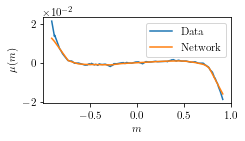

 17%|█▋        | 1195/7000 [00:04<00:23, 249.47it/s]

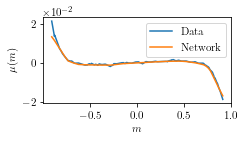

 18%|█▊        | 1243/7000 [00:04<00:27, 207.83it/s]

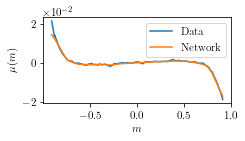

 20%|█▉        | 1373/7000 [00:05<00:23, 242.08it/s]

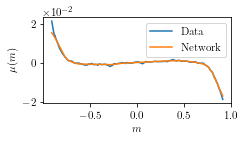

 21%|██▏       | 1493/7000 [00:05<00:21, 255.17it/s]

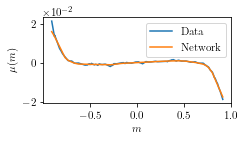

 22%|██▏       | 1540/7000 [00:06<00:26, 209.09it/s]

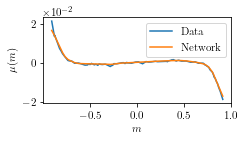

 24%|██▍       | 1675/7000 [00:06<00:20, 255.62it/s]

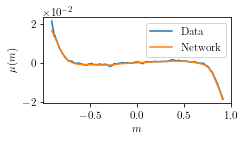

 26%|██▌       | 1793/7000 [00:06<00:19, 261.90it/s]

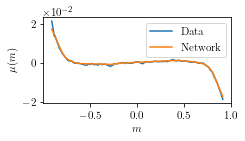

 26%|██▋       | 1840/7000 [00:07<00:24, 212.03it/s]

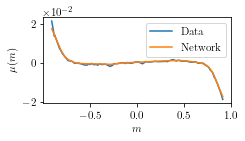

 28%|██▊       | 1978/7000 [00:07<00:20, 248.89it/s]

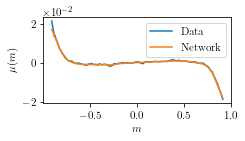

 29%|██▉       | 2023/7000 [00:08<00:24, 203.28it/s]

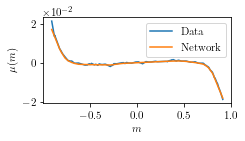

 31%|███       | 2177/7000 [00:08<00:18, 265.45it/s]

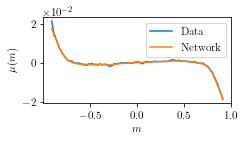

 33%|███▎      | 2294/7000 [00:08<00:18, 255.70it/s]

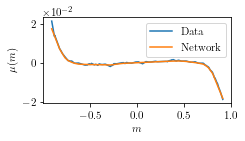

 33%|███▎      | 2341/7000 [00:09<00:22, 210.19it/s]

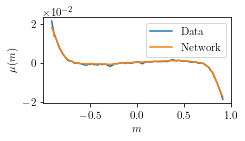

 35%|███▌      | 2475/7000 [00:09<00:19, 236.11it/s]

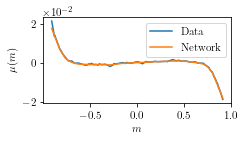

 37%|███▋      | 2596/7000 [00:10<00:17, 251.21it/s]

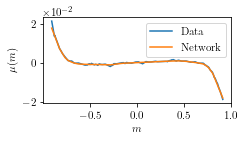

 38%|███▊      | 2644/7000 [00:10<00:20, 208.92it/s]

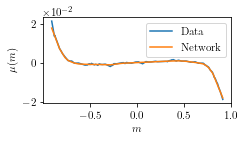

 40%|███▉      | 2776/7000 [00:10<00:16, 251.69it/s]

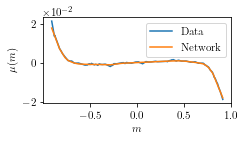

 41%|████      | 2882/7000 [00:11<00:16, 254.46it/s]

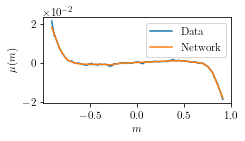

 42%|████▏     | 2926/7000 [00:11<00:20, 201.81it/s]

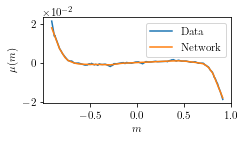

 44%|████▍     | 3074/7000 [00:12<00:15, 253.51it/s]

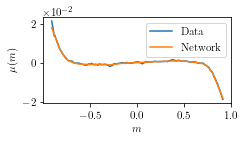

 46%|████▌     | 3191/7000 [00:12<00:14, 258.34it/s]

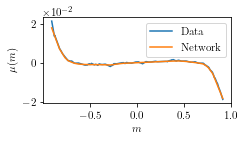

 46%|████▌     | 3237/7000 [00:12<00:18, 204.81it/s]

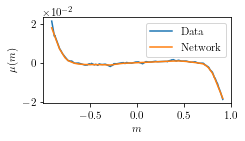

 48%|████▊     | 3371/7000 [00:13<00:14, 253.19it/s]

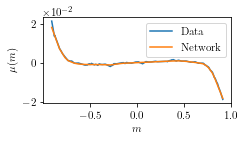

 50%|████▉     | 3486/7000 [00:13<00:13, 256.46it/s]

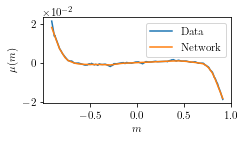

 50%|█████     | 3532/7000 [00:14<00:17, 197.90it/s]

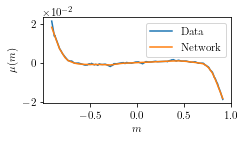

 52%|█████▎    | 3675/7000 [00:14<00:13, 245.44it/s]

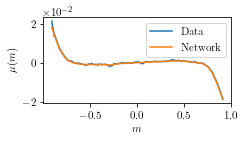

 54%|█████▍    | 3793/7000 [00:15<00:12, 254.81it/s]

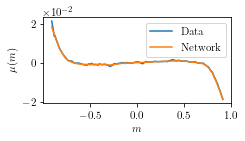

 55%|█████▍    | 3840/7000 [00:15<00:16, 191.67it/s]

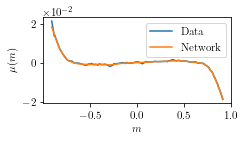

 57%|█████▋    | 3974/7000 [00:15<00:12, 241.61it/s]

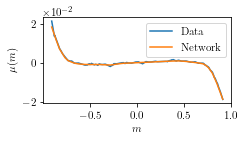

 58%|█████▊    | 4091/7000 [00:16<00:11, 253.63it/s]

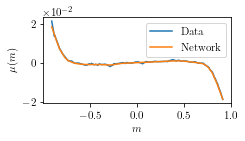

 59%|█████▉    | 4138/7000 [00:16<00:13, 206.28it/s]

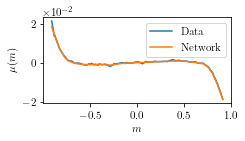

 61%|██████    | 4256/7000 [00:17<00:11, 243.48it/s]

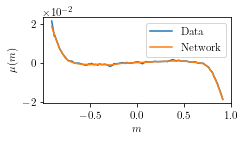

 62%|██████▏   | 4371/7000 [00:17<00:10, 249.52it/s]

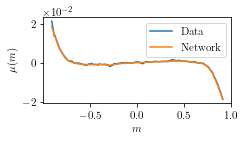

 64%|██████▍   | 4481/7000 [00:17<00:10, 249.16it/s]

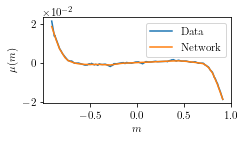

 66%|██████▌   | 4595/7000 [00:18<00:09, 252.92it/s]

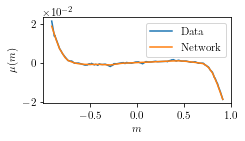

 66%|██████▋   | 4641/7000 [00:18<00:11, 201.66it/s]

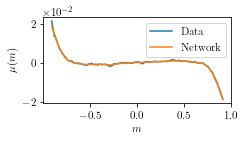

 68%|██████▊   | 4769/7000 [00:19<00:09, 235.53it/s]

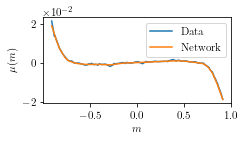

 70%|██████▉   | 4883/7000 [00:19<00:08, 242.23it/s]

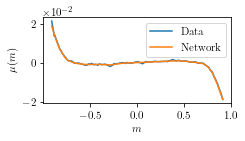

 71%|███████▏  | 4998/7000 [00:20<00:07, 250.91it/s]

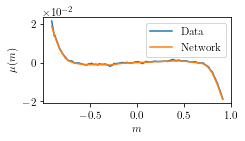

 72%|███████▏  | 5044/7000 [00:20<00:09, 196.28it/s]

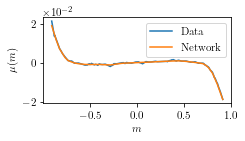

 74%|███████▍  | 5170/7000 [00:20<00:07, 238.12it/s]

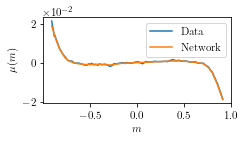

 76%|███████▌  | 5286/7000 [00:21<00:07, 221.48it/s]

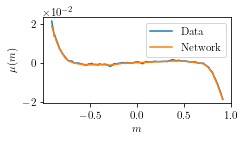

 76%|███████▌  | 5331/7000 [00:21<00:09, 180.63it/s]

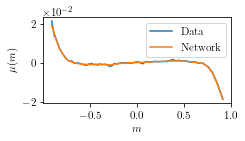

 78%|███████▊  | 5469/7000 [00:22<00:06, 237.17it/s]

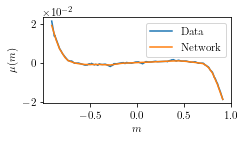

 80%|███████▉  | 5583/7000 [00:22<00:05, 245.98it/s]

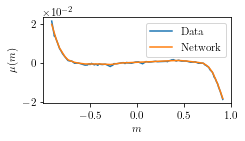

 80%|████████  | 5628/7000 [00:22<00:06, 201.32it/s]

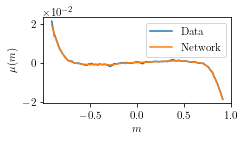

 82%|████████▏ | 5772/7000 [00:23<00:04, 257.11it/s]

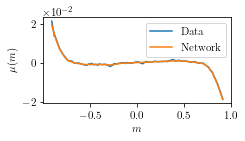

 84%|████████▍ | 5890/7000 [00:23<00:04, 259.19it/s]

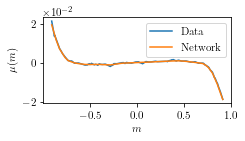

 85%|████████▍ | 5937/7000 [00:24<00:05, 200.26it/s]

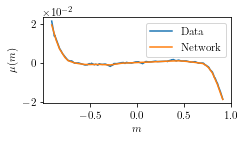

 87%|████████▋ | 6072/7000 [00:24<00:03, 249.26it/s]

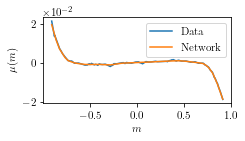

 88%|████████▊ | 6187/7000 [00:25<00:03, 255.22it/s]

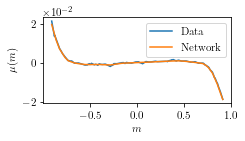

 89%|████████▉ | 6233/7000 [00:25<00:03, 207.20it/s]

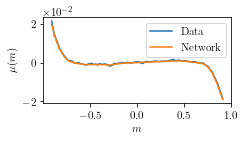

 91%|█████████ | 6372/7000 [00:25<00:02, 257.82it/s]

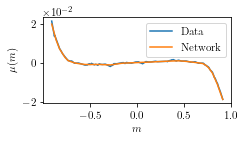

 93%|█████████▎| 6489/7000 [00:26<00:01, 261.41it/s]

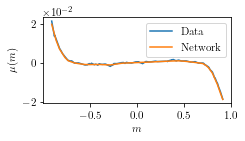

 93%|█████████▎| 6535/7000 [00:26<00:02, 199.23it/s]

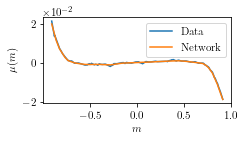

 95%|█████████▌| 6672/7000 [00:27<00:01, 237.69it/s]

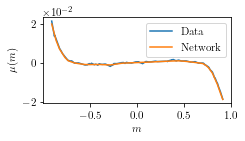

 97%|█████████▋| 6786/7000 [00:27<00:00, 248.63it/s]

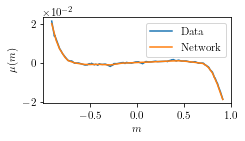

 98%|█████████▊| 6831/7000 [00:27<00:00, 202.45it/s]

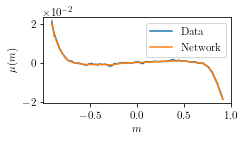

100%|█████████▉| 6972/7000 [00:28<00:00, 256.04it/s]

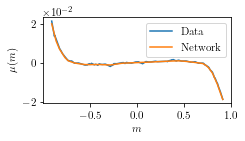

100%|██████████| 7000/7000 [00:28<00:00, 245.17it/s]


Training for model 9


  1%|          | 78/7000 [00:00<00:08, 775.92it/s]

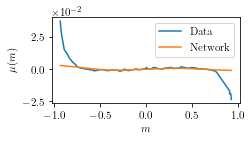

  2%|▎         | 175/7000 [00:00<00:24, 274.73it/s]

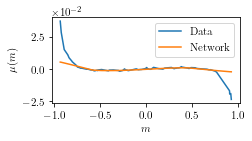

  4%|▍         | 286/7000 [00:00<00:27, 245.96it/s]

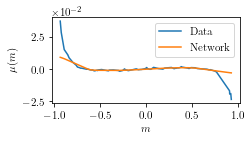

  5%|▍         | 329/7000 [00:01<00:34, 195.86it/s]

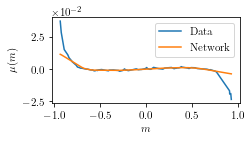

  7%|▋         | 473/7000 [00:01<00:25, 251.07it/s]

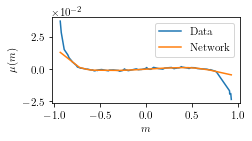

  8%|▊         | 595/7000 [00:02<00:25, 252.58it/s]

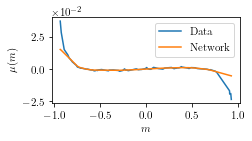

  9%|▉         | 642/7000 [00:02<00:32, 196.06it/s]

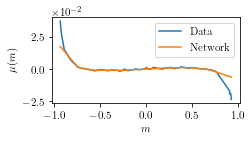

 11%|█         | 773/7000 [00:02<00:25, 241.75it/s]

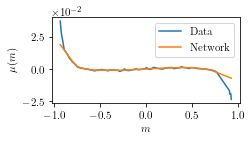

 13%|█▎        | 889/7000 [00:03<00:24, 250.58it/s]

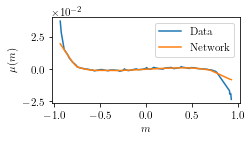

 13%|█▎        | 935/7000 [00:03<00:30, 199.43it/s]

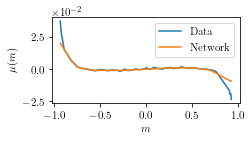

 15%|█▌        | 1077/7000 [00:04<00:25, 235.53it/s]

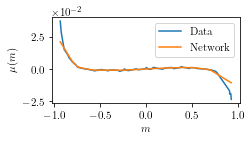

 17%|█▋        | 1196/7000 [00:04<00:23, 247.74it/s]

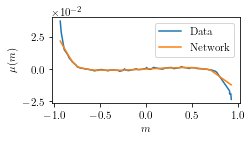

 18%|█▊        | 1243/7000 [00:05<00:29, 193.84it/s]

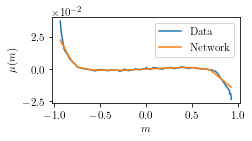

 20%|█▉        | 1374/7000 [00:05<00:23, 238.99it/s]

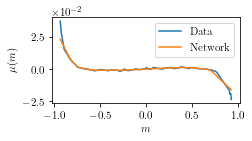

 21%|██▏       | 1495/7000 [00:05<00:21, 250.23it/s]

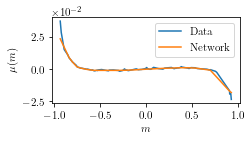

 22%|██▏       | 1543/7000 [00:06<00:26, 205.25it/s]

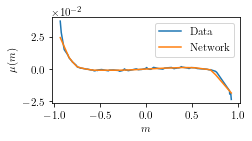

 24%|██▍       | 1678/7000 [00:06<00:21, 246.07it/s]

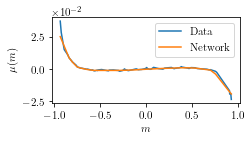

 26%|██▌       | 1797/7000 [00:07<00:20, 253.73it/s]

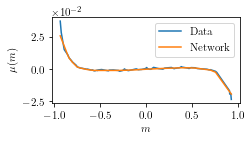

 26%|██▋       | 1844/7000 [00:07<00:26, 196.47it/s]

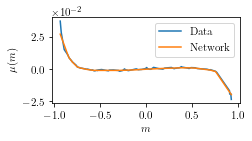

 28%|██▊       | 1975/7000 [00:07<00:20, 240.45it/s]

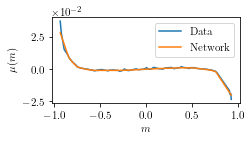

 30%|██▉       | 2098/7000 [00:08<00:19, 251.90it/s]

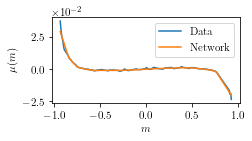

 31%|███       | 2146/7000 [00:08<00:23, 207.38it/s]

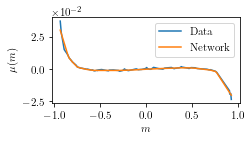

 32%|███▏      | 2274/7000 [00:09<00:19, 245.62it/s]

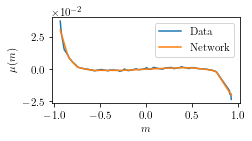

 34%|███▍      | 2390/7000 [00:09<00:20, 227.32it/s]

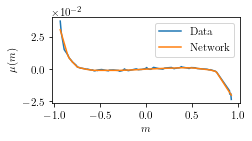

 35%|███▍      | 2436/7000 [00:09<00:23, 191.81it/s]

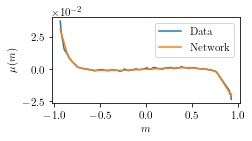

 37%|███▋      | 2575/7000 [00:10<00:18, 243.63it/s]

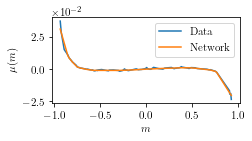

 38%|███▊      | 2693/7000 [00:10<00:17, 251.89it/s]

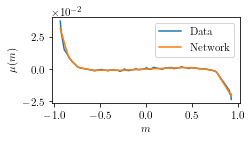

 39%|███▉      | 2740/7000 [00:11<00:20, 204.79it/s]

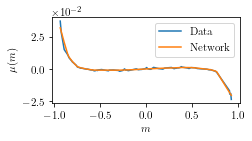

 41%|████      | 2874/7000 [00:11<00:16, 249.23it/s]

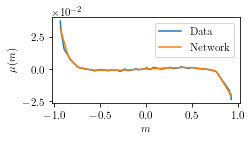

 43%|████▎     | 2986/7000 [00:12<00:16, 238.09it/s]

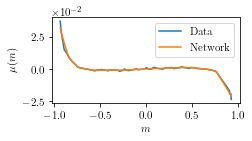

 43%|████▎     | 3031/7000 [00:12<00:20, 196.24it/s]

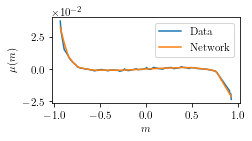

 45%|████▌     | 3178/7000 [00:12<00:15, 250.29it/s]

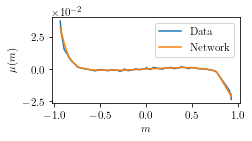

 46%|████▌     | 3223/7000 [00:13<00:18, 200.82it/s]

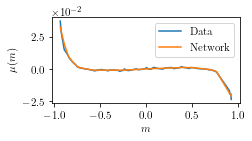

 48%|████▊     | 3375/7000 [00:13<00:13, 260.99it/s]

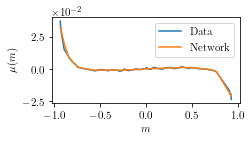

 50%|████▉     | 3496/7000 [00:14<00:13, 257.85it/s]

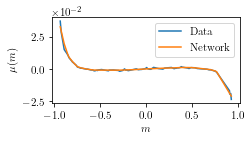

 51%|█████     | 3543/7000 [00:14<00:17, 198.23it/s]

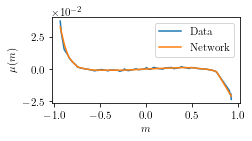

 52%|█████▎    | 3675/7000 [00:14<00:14, 228.73it/s]

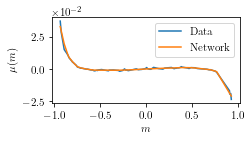

 54%|█████▍    | 3795/7000 [00:15<00:13, 243.84it/s]

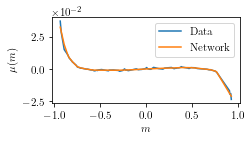

 55%|█████▍    | 3842/7000 [00:15<00:15, 200.03it/s]

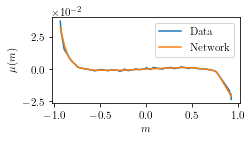

 57%|█████▋    | 3974/7000 [00:16<00:12, 243.52it/s]

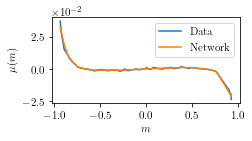

 58%|█████▊    | 4093/7000 [00:16<00:12, 241.10it/s]

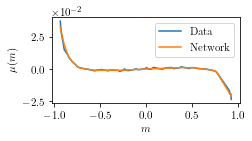

 59%|█████▉    | 4140/7000 [00:16<00:14, 190.89it/s]

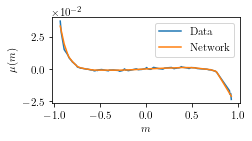

 61%|██████    | 4276/7000 [00:17<00:11, 240.59it/s]

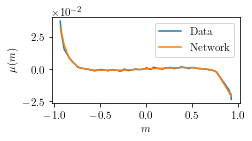

 63%|██████▎   | 4395/7000 [00:17<00:10, 251.31it/s]

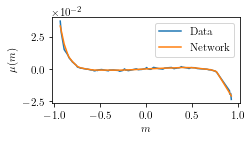

 63%|██████▎   | 4442/7000 [00:18<00:12, 200.86it/s]

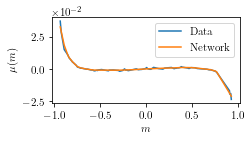

 65%|██████▌   | 4578/7000 [00:18<00:09, 245.49it/s]

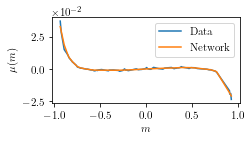

 67%|██████▋   | 4697/7000 [00:19<00:09, 243.81it/s]

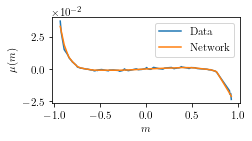

 68%|██████▊   | 4744/7000 [00:19<00:11, 199.36it/s]

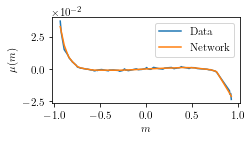

 70%|██████▉   | 4877/7000 [00:19<00:08, 240.95it/s]

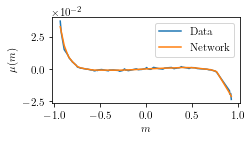

 71%|███████▏  | 4998/7000 [00:20<00:08, 233.76it/s]

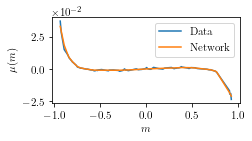

 72%|███████▏  | 5045/7000 [00:20<00:10, 194.65it/s]

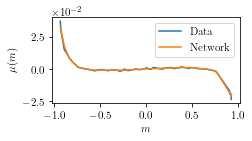

 74%|███████▍  | 5177/7000 [00:21<00:07, 238.66it/s]

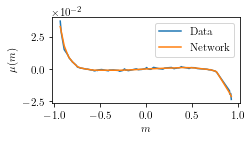

 76%|███████▌  | 5297/7000 [00:21<00:07, 240.82it/s]

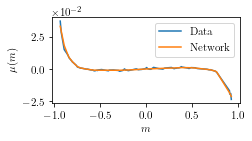

 76%|███████▋  | 5344/7000 [00:21<00:08, 198.48it/s]

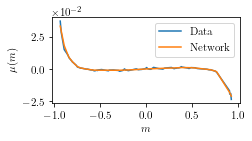

 78%|███████▊  | 5474/7000 [00:22<00:06, 241.26it/s]

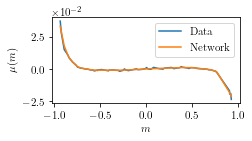

 80%|███████▉  | 5590/7000 [00:22<00:05, 249.97it/s]

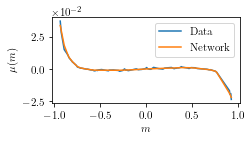

 81%|████████  | 5636/7000 [00:23<00:06, 202.28it/s]

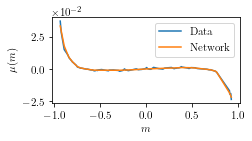

 82%|████████▏ | 5772/7000 [00:23<00:04, 248.34it/s]

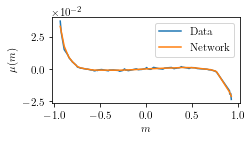

 84%|████████▍ | 5893/7000 [00:24<00:04, 242.77it/s]

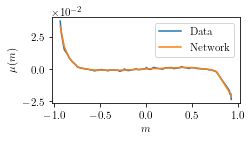

 85%|████████▍ | 5940/7000 [00:24<00:05, 199.25it/s]

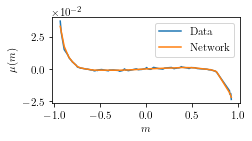

 87%|████████▋ | 6072/7000 [00:24<00:03, 244.55it/s]

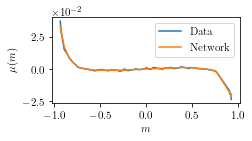

 88%|████████▊ | 6189/7000 [00:25<00:03, 251.24it/s]

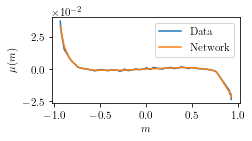

 89%|████████▉ | 6235/7000 [00:25<00:04, 186.17it/s]

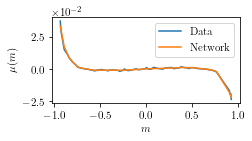

 91%|█████████ | 6372/7000 [00:26<00:02, 238.15it/s]

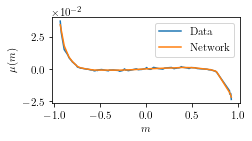

 93%|█████████▎| 6486/7000 [00:26<00:02, 245.25it/s]

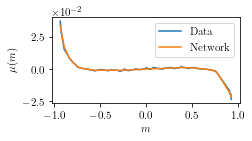

 93%|█████████▎| 6531/7000 [00:26<00:02, 198.39it/s]

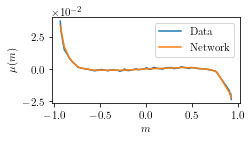

 95%|█████████▌| 6671/7000 [00:27<00:01, 250.55it/s]

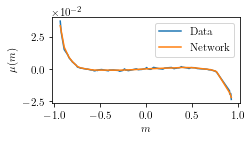

 97%|█████████▋| 6787/7000 [00:27<00:00, 252.24it/s]

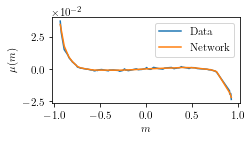

 98%|█████████▊| 6833/7000 [00:28<00:00, 202.45it/s]

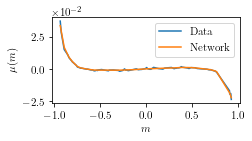

100%|█████████▉| 6973/7000 [00:28<00:00, 240.75it/s]

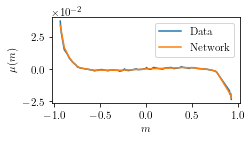

100%|██████████| 7000/7000 [00:28<00:00, 241.83it/s]


In [78]:
import tqdm
mu = AverageMu() 
ds = dataset(data_set)
mu = train_avg_mu(mu,ds,"./dump")

# Learning $\sigma_\theta$

To learn the diffusion we make use of the quadratic variantion. For a Stochastic process 
$$
dZ_t = \mu(Z_t)dt + \sigma(Z_t)dW_t, \qquad Z_0=x
$$
the quadratic variation is defined as:

$$
[Z]_t
=
\lim_{u\to0^+}\sum_{s=0}^t(Z_{s+u}-Z_s)^2
$$

This quantity equals


$$
[Z]_t
=
\int_0^t ds \sigma(Z_s)
$$

Thus, we choose to train $\sigma_\theta$ on:

$$
L[\sigma_\theta](\theta)=
\left|
\sigma^2(Z_t) - \frac{  [Z]_{t+u}-[Z]_t}{u}\
\right|
$$

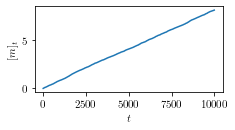

In [67]:
#a plot of the quadratic variation, 

qv = np.cumsum((np.array(f["m1_1"])[1:]-np.array(f["m1_1"])[:-1])**2)
time = np.arange(len(qv))
delta_u = 50
plt.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
            "font.size":11
         })
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4.7747/1.35, h=2.9841875*0.65)
fig.tight_layout(pad=1.5)
ax.plot(time,qv)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$[m]_t$")
#sigma2 = qv[0::delta_u][1:]-qv[0::delta_u][:-1]
#ax.plot(time[0::delta_u][:199], sigma2[:199])
plt.show
plt.savefig("./images/qv.pdf")

#As sigma2 is a constant, the quadratic variation grows linearly in time:

In [79]:
#define the network we use as sigma2
class Sigma2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Sigma2, self).__init__()
        self.sigma_net = nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.Tanh(),
                    nn.Linear(hidden_size, hidden_size),
                    nn.Tanh(),
                    nn.Linear(hidden_size, output_size),
                    nn.Sigmoid(),
                    )   

    def forward(self,v):
            sigma2 = self.sigma_net(v[2])**2
            return sigma2

class WeightedSigma(nn.Module):
        """ 
        A model for the diffusion which is a weighted average of other models
        """
        def __init__(   self,
                n_train = 10, 
                input_size=1, 
                hidden_size=64,
                output_size=1,
                ):  
                super(WeightedSigma, self).__init__()
                self.funcs = nn.ModuleList([
                Sigma2(
                        input_size, hidden_size, output_size
                        ) for _ in range(n_train)])
                self.weights = torch.ones(n_train,requires_grad=False)
                self.n_train = n_train

        def forward(self,x):
                y = torch.zeros_like(x)
                for idx in range(self.n_train):
                        y = y+ self.weights[idx].flatten()*self.funcs[idx].sigma_net.forward(x)
                return y/(self.weights.sum())
        
        

In [102]:
def load_ising_dataset(t0,t1,file_name,device,steps):
        data_h5 = h5py.File(file_name,'r')
        keys = [key for key in data_h5.keys()]
        data = np.array(data_h5[keys[0]])
        for key in keys[1:]:
                data = np.concatenate((data,np.array(data_h5[key])))
        dta_len = int(len(data)/steps)
        ts = torch.linspace(0., float(steps), steps=steps, device=device)
        xs = torch.from_numpy(data.reshape(int(len(data)/steps),steps,1)).float()
        #xs = torch.abs(xs)
        return xs,ts

#Define the dataset
class Data_sigma_p_train(Dataset):
    def __init__(
                    self,
                    file_name,
                    delta_t,
                    device= "cpu",
                    n_steps=t_max,
    ):
        self.delta_t = delta_t
        self.xs, self.time = load_ising_dataset(0.,1.,file_name,device,steps = n_steps)
        self.xs = self.xs
        dx2 = (self.xs.T[:,1:,:]-self.xs.T[:,:-1,:])**2
        qv_dx2 = torch.cumsum(dx2.T,1)
        coarse_qv_dx2 = qv_dx2.T[:,0::self.delta_t,:]
        self.qv = coarse_qv_dx2.T
        self.num = len(self.qv)
        self.coarse_xs = self.xs.T[:,0::self.delta_t,:].T
        # data is organized in tuples ( [X]_t, [X]_t+dt,X_t   )
        data = torch.cat(
                            (
                                    self.qv.T[:,:-1,:].T, # [X]_t
                                    self.qv.T[:,1:,:].T, # [X]_t+dt 
                                    self.coarse_xs.T[:,:-1,:].T, #X_t 
                            ),
                                dim = 2,
                                )
        self.dataset = data.reshape( (data.shape[0]*data.shape[1],3,1) )
        self.num = int(len(self.dataset))
    def __getitem__(self, idx):
        return self.dataset[(idx+1)% self.num].float()
    def __len__(self):
        return self.num

In [163]:
#define training procedure
def train_sigma(model,
                train_dir,
                dataset,
                delta_t,
                batch_size=1000,
                input_size=1,
                hidden_size=64,
                output_size=1,
                num_iters=2000,
                stop_every= 400
                ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)
    for global_step in tqdm.tqdm(range(1, num_iters+1)):
            xs = torch.transpose(next(iter(infinite_train_dataloader)),0,1)
            model.zero_grad()
            loss = torch.abs( (xs[1] -xs[0])/(delta_t) -  model(xs)).mean()
            if global_step%stop_every==0:
                print(loss.item())
            #    with torch.no_grad():
            #        delta_qv = (xs[1] -xs[0])/delta_t
            #        sigma2 = model(xs)
            #        plt.plot(delta_qv,  sigma2)
            #        plt.show()

            loss.backward()
            optimizer.step()
            
    w = ((( (xs[1] -xs[0])/delta_t -  model(xs))**2).mean())**(-1)
    return model, w
    plt.close()
    


In [164]:
device="cpu"
T = T
n_train = 5
t_final = 1000
input_size = 1
hidden_size = 64
output_size = 1
train_dir = "dump/ising_sigma_%.4f_N_%d"%(T,Size_system)
os.makedirs(train_dir, exist_ok=True)
model = Sigma2(
            input_size, hidden_size, output_size
            )
dataset = Data_sigma_p_train(
            data_set,
            delta_u,
            device=device
            )
sigma = WeightedSigma()
counter = 0
for s, w in zip(sigma.funcs,sigma.weights):
    print("training for %d -th model"%counter)
    counter+=1
    s,w = train_sigma(s,
                      train_dir,
                      dataset,
                      delta_t=delta_u)



  0%|          | 10/2000 [00:00<00:20, 98.61it/s]

training for 0 -th model


 21%|██        | 417/2000 [00:03<00:14, 109.26it/s]

0.0002174918190576136


 41%|████      | 814/2000 [00:07<00:11, 101.21it/s]

0.00016444685752503574


 61%|██████    | 1213/2000 [00:11<00:07, 100.32it/s]

0.00015579976025037467


 81%|████████  | 1611/2000 [00:15<00:03, 105.15it/s]

0.00015216923202387989


  1%|          | 11/2000 [00:00<00:19, 103.49it/s]

0.00014667700452264398
training for 1 -th model


 21%|██        | 412/2000 [00:03<00:14, 111.02it/s]

0.00018358853412792087


 41%|████      | 820/2000 [00:07<00:10, 113.27it/s]

0.0001730879012029618


 60%|██████    | 1209/2000 [00:11<00:08, 98.48it/s] 

0.00015982260811142623


 81%|████████  | 1618/2000 [00:15<00:03, 109.80it/s]

0.000146972801303491


  1%|          | 12/2000 [00:00<00:17, 112.65it/s]

0.00015242454537656158
training for 2 -th model


 20%|██        | 407/2000 [00:06<00:27, 58.97it/s] 

0.0001964382390724495


 41%|████      | 815/2000 [00:12<00:11, 99.28it/s] 

0.0001735647238092497


 61%|██████    | 1219/2000 [00:16<00:08, 93.33it/s] 

0.0001507760607637465


 80%|████████  | 1609/2000 [00:20<00:03, 99.85it/s] 

0.00014978615217842162


  1%|          | 13/2000 [00:00<00:16, 120.57it/s]

0.00015803216956555843
training for 3 -th model


 21%|██        | 419/2000 [00:03<00:13, 116.68it/s]

0.0002027867449214682


 41%|████      | 814/2000 [00:07<00:13, 86.92it/s] 

0.00014809484127908945


 61%|██████    | 1215/2000 [00:11<00:06, 114.95it/s]

0.00015596969751641154


 81%|████████  | 1612/2000 [00:15<00:03, 104.79it/s]

0.0001389981189277023


  1%|          | 12/2000 [00:00<00:18, 110.27it/s]

0.00013483921065926552
training for 4 -th model


 21%|██        | 417/2000 [00:04<00:14, 111.11it/s]

0.00019493770378176123


 41%|████      | 816/2000 [00:07<00:10, 111.73it/s]

0.00018872658256441355


 61%|██████    | 1215/2000 [00:11<00:07, 105.68it/s]

0.00016592434258200228


 81%|████████  | 1621/2000 [00:15<00:03, 111.22it/s]

0.00014418545470107347


  1%|          | 11/2000 [00:00<00:18, 104.76it/s]

0.00015070255903992802
training for 5 -th model


 21%|██        | 419/2000 [00:03<00:15, 101.11it/s]

0.0001957663189386949


 41%|████      | 818/2000 [00:07<00:10, 110.56it/s]

0.0001712360099190846


 61%|██████    | 1213/2000 [00:11<00:07, 112.24it/s]

0.00014964339789003134


 81%|████████  | 1621/2000 [00:15<00:03, 109.89it/s]

0.0001678278495091945


  1%|          | 11/2000 [00:00<00:18, 107.09it/s]

0.00014806145918555558
training for 6 -th model


 21%|██        | 417/2000 [00:03<00:15, 104.07it/s]

0.00022266176529228687


 41%|████      | 812/2000 [00:07<00:10, 115.40it/s]

0.00016468801186420023


 61%|██████    | 1219/2000 [00:10<00:06, 112.60it/s]

0.000140773830935359


 81%|████████  | 1615/2000 [00:14<00:03, 114.80it/s]

0.00013723310257773846


  1%|          | 11/2000 [00:00<00:18, 108.20it/s]

0.0001475585886510089
training for 7 -th model


 21%|██        | 415/2000 [00:03<00:15, 105.13it/s]

0.00020371205755509436


 41%|████      | 822/2000 [00:07<00:10, 115.13it/s]

0.00018113139958586544


 61%|██████    | 1218/2000 [00:10<00:06, 114.47it/s]

0.0001488014095230028


 81%|████████  | 1614/2000 [00:14<00:03, 113.76it/s]

0.00014168251072987914


  0%|          | 10/2000 [00:00<00:20, 99.43it/s]

0.00014031186583451927
training for 8 -th model


 21%|██        | 418/2000 [00:03<00:13, 114.91it/s]

0.00018310235464014113


 41%|████      | 814/2000 [00:07<00:10, 113.68it/s]

0.0001796711585484445


 61%|██████    | 1220/2000 [00:10<00:06, 114.10it/s]

0.0001499353238614276


 81%|████████  | 1616/2000 [00:14<00:03, 112.72it/s]

0.00014209043001756072


  1%|          | 12/2000 [00:00<00:17, 112.26it/s]

0.00015493114187847823
training for 9 -th model


 21%|██        | 418/2000 [00:03<00:13, 113.74it/s]

0.00022484929650090635


 41%|████      | 813/2000 [00:07<00:10, 114.17it/s]

0.0001673964288784191


 61%|██████    | 1214/2000 [00:10<00:07, 110.61it/s]

0.0001481752551626414


 81%|████████  | 1618/2000 [00:14<00:03, 110.88it/s]

0.00015747148427180946


100%|██████████| 2000/2000 [00:17<00:00, 111.90it/s]


0.0001450178533559665


In [185]:
#plot the results
def plot_sigma(sigma,mu,dt,delta_t):
        with torch.no_grad():
            plt.rcParams.update({
                "pgf.texsystem": "pdflatex",
                'font.family': 'serif',
                'text.usetex': True,
                'pgf.rcfonts': False,
                "font.size":9
             })
            x=torch.linspace(-1,1,100).reshape(100,1)
            plt.subplots_adjust(bottom=0.19)
            fig, (ax1,ax2) = plt.subplots(1, 2)
            fig.set_size_inches(w=4.7747/1.35, h=2.9841875*0.65)
            fig.tight_layout(pad =1.8)
            ax1.text(-0.15, 1.1, "(a)", transform=ax1.transAxes)
            ax1.ticklabel_format(style="sci",scilimits=(-0.2,0))
            ax2.ticklabel_format(style="sci",scilimits=(-0.2,0))
            ax2.text(-0.15, 1.1, "(b)", transform=ax2.transAxes)
            sigma_x = sigma(x).flatten()
            mu_x = dt*mu(x)
            ax1.plot(x.flatten(),sigma_x,c="tab:red",label = r"$\sigma_\theta$")
            ax1.plot(x.flatten(),mu_x,label =r"$\mu_\theta$",alpha = .5,c="tab:blue")
            box = ax1.get_position()
            ax1.set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
            ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),frameon=False)       
            ax1.set_xlabel(r"$m$")
            ax2.set
            ax1.get_xaxis().get_offset_text().set_position((0.2,0.))
            delta_mt = (dataset.qv.T[:,1:,:].T[0] -dataset.qv.T[:,:-1,:].T[0] )/delta_t
            ax2.plot( delta_mt, c= "dimgrey",
                            label =r"$\Delta_t [m]_t$" )
            ax2.plot( (sigma(dataset.coarse_xs[0])**2),color="black",
                            label = r"$\sigma_\theta^2(m_t)$")
            max_d = torch.abs(delta_mt).max().item()
            min_d = torch.abs(delta_mt).min().item()
            print(max_d)
            ax2.set_ylim(min_d-max_d,min_d+2*max_d)
            box = ax2.get_position()
            ax2.set_position([box.x0-0.05, box.y0, box.width*1.3, box.height])
            ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),frameon=False)
            ax2.set_xlabel(r"$t$")
            #plt.savefig( "./images/sigma2_T_%.3f.pdf"%args.T)
            plt.show()
            plt.close()



0.0012953185942023993


<Figure size 432x288 with 0 Axes>

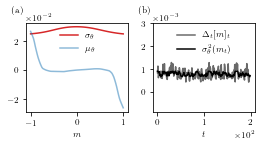

In [186]:
plot_sigma(sigma,mu,dt,delta_t=delta_u)

In [ ]:
#the system size is small (32x32 spins), so jumps really do happen between the two minima in the, effective free energy
#which lead to a rather "bell shaped" form of the noise